# Phase 3: Exploratory Data Analysis (EDA)

This notebook performs comprehensive exploratory analysis of the fused e-commerce dataset.

## Objectives
1. Understand dataset structure and quality
2. Analyze distributions of key variables
3. Explore relationships between features
4. Perform statistical tests
5. Generate visualizations
6. Document insights and findings


## 1. Setup and Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Project paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed" / "fused"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"

# Create figures directory if it doesn't exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Processed data: {PROCESSED_DIR}")


Project root: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights
Data directory: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\data
Processed data: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\data\processed\fused


## 2. Load Fused Dataset


In [2]:
# Load fused dataset with ULTRA memory-efficient approach to prevent IDE crashes
import pyarrow.parquet as pq
import gc

fused_file = PROCESSED_DIR / "books_books_fused.parquet"

print(f"Loading fused dataset from: {fused_file}")
print(f"File exists: {fused_file.exists()}")

# ULTRA conservative loading: Maximum 50,000 rows to prevent IDE crashes
if fused_file.exists():
    # Read metadata without loading full dataset
    parquet_file = pq.ParquetFile(fused_file)
    num_rows = parquet_file.metadata.num_rows
    file_size_mb = fused_file.stat().st_size / (1024**2)
    num_row_groups = parquet_file.num_row_groups
    
    print(f"File size: {file_size_mb:.2f} MB")
    print(f"Total rows in file: {num_rows:,}")
    print(f"Number of row groups: {num_row_groups}")
    
    # VERY conservative sample size - max 50k rows to prevent IDE crashes
    MAX_SAMPLE_SIZE = 50_000  # Hard limit to prevent crashes
    
    if num_rows > MAX_SAMPLE_SIZE:
        sample_size = MAX_SAMPLE_SIZE
        print(f"\n⚠️  Dataset is VERY large ({num_rows:,} rows).")
        print(f"   Sampling {sample_size:,} rows for EDA to prevent IDE crashes...")
        print(f"   This represents {sample_size/num_rows*100:.2f}% of the full dataset.")
        
        # Read only 1-2 row groups at a time to minimize memory usage
        # Try to read multiple row groups (up to 20) to ensure we get data even if some fail
        max_row_groups_to_try = min(20, num_row_groups)  # Try up to 20 row groups
        rng = np.random.RandomState(42)
        row_groups_to_try = sorted(rng.choice(num_row_groups,
                                              size=max_row_groups_to_try,
                                              replace=False))

        print(f"Attempting to read from {len(row_groups_to_try)} row groups...")
        batches = []
        failed_groups = []

        for rg_idx in row_groups_to_try:
            try:
                # Read row group
                batch = parquet_file.read_row_groups([rg_idx]).to_pandas()

                # Handle dictionary/object columns that might cause issues
                for col in batch.columns:
                    try:
                        # Check if column contains dictionaries or complex objects
                        if batch[col].dtype == "object":
                            # Sample a few values to check type
                            sample_vals = batch[col].dropna().head(5)
                            if len(sample_vals) > 0:
                                # If any value is a dict, convert to string
                                if any(isinstance(val, dict) for val in sample_vals):
                                    batch[col] = batch[col].astype(str)
                                # Otherwise, try to convert to category if low cardinality
                                elif batch[col].nunique() / len(batch) < 0.5:
                                    try:
                                        batch[col] = batch[col].astype("category")
                                    except:
                                        pass  # Keep as object if conversion fails
                        elif batch[col].dtype == "int64":
                            batch[col] = pd.to_numeric(batch[col], downcast="integer")
                        elif batch[col].dtype == "float64":
                            batch[col] = pd.to_numeric(batch[col], downcast="float")
                    except Exception as col_error:
                        # If column processing fails, convert to string as fallback
                        try:
                            batch[col] = batch[col].astype(str)
                        except:
                            pass  # Skip column if even string conversion fails

                batches.append(batch)
                print(f"  ✓ Successfully read row group {rg_idx} ({len(batch):,} rows)")

                # Early exit if we have enough data
                total_rows_so_far = sum(len(b) for b in batches)
                if total_rows_so_far >= sample_size * 1.5:  # Get 1.5x for better sampling
                    print(f"  ✓ Collected {total_rows_so_far:,} rows, enough for sampling")
                    break
            except Exception as e:
                failed_groups.append(rg_idx)
                print(f"  ✗ Warning: Could not read row group {rg_idx}: {str(e)[:100]}")
                continue

        if failed_groups:
            print(f"\n⚠️  Failed to read {len(failed_groups)} row groups, but continuing with successful ones...")
        if batches:
            # Combine batches and sample
            print("Combining batches...")
            df_temp = pd.concat(batches, ignore_index=True)
            print(f"Combined batches: {len(df_temp):,} rows")
            
            # Free memory immediately
            del batches
            gc.collect()
            
            # Sample to exact size
            if len(df_temp) > sample_size:
                df_sample = df_temp.sample(n=sample_size, random_state=42)
            else:
                df_sample = df_temp.copy()
            
            # Free memory
            del df_temp
            gc.collect()
            
            # Final optimization
            print("Final data type optimization...")
            for col in df_sample.columns:
                if df_sample[col].dtype == 'object':
                    if df_sample[col].nunique() / len(df_sample) < 0.5:
                        df_sample[col] = df_sample[col].astype('category')
                elif df_sample[col].dtype == 'int64':
                    df_sample[col] = pd.to_numeric(df_sample[col], downcast='integer')
                elif df_sample[col].dtype == 'float64':
                    df_sample[col] = pd.to_numeric(df_sample[col], downcast='float')
        else:
            raise ValueError("Could not read any data from parquet file")
    else:
        # Small dataset - load directly
        print("Loading full dataset (small enough to load directly)...")
        df_sample = pd.read_parquet(fused_file)
        
        # Optimize data types
        for col in df_sample.columns:
            if df_sample[col].dtype == 'object':
                if df_sample[col].nunique() / len(df_sample) < 0.5:
                    df_sample[col] = df_sample[col].astype('category')
            elif df_sample[col].dtype == 'int64':
                df_sample[col] = pd.to_numeric(df_sample[col], downcast='integer')
            elif df_sample[col].dtype == 'float64':
                df_sample[col] = pd.to_numeric(df_sample[col], downcast='float')
    
    # Final garbage collection
    gc.collect()
    
    print(f"\n✅ Dataset loaded successfully!")
    print(f"   Shape: {df_sample.shape}")
    print(f"   Memory usage: {df_sample.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    if num_rows > MAX_SAMPLE_SIZE:
        print(f"   Sample represents: {len(df_sample)/num_rows*100:.2f}% of full dataset")
else:
    raise FileNotFoundError(f"File not found: {fused_file}")

Loading fused dataset from: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\data\processed\fused\books_books_fused.parquet
File exists: True
File size: 14964.61 MB
Total rows in file: 26,908,145
Number of row groups: 272

⚠️  Dataset is VERY large (26,908,145 rows).
   Sampling 50,000 rows for EDA to prevent IDE crashes...
   This represents 0.19% of the full dataset.
Attempting to read from 20 row groups...
  ✓ Successfully read row group 30 (99,120 rows)
  ✓ Collected 99,120 rows, enough for sampling
Combining batches...
Combined batches: 99,120 rows
Final data type optimization...

✅ Dataset loaded successfully!
   Shape: (50000, 50)
   Memory usage: 53.56 MB
   Sample represents: 0.19% of full dataset


## 3. Dataset Overview


In [3]:
# Basic info
print("=== DATASET OVERVIEW ===")
print(f"Rows: {len(df_sample):,}")
print(f"Columns: {len(df_sample.columns)}")
print(f"\nColumn names:")
for i, col in enumerate(df_sample.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n=== DATA TYPES ===")
print(df_sample.dtypes)

print("\n=== MISSING VALUES ===")
missing = df_sample.isnull().sum()
missing_pct = (missing / len(df_sample)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df.to_string(index=False))


=== DATASET OVERVIEW ===
Rows: 50,000
Columns: 50

Column names:
   1. overall
   2. verified
   3. reviewTime
   4. reviewerID
   5. asin
   6. style
   7. reviewerName
   8. reviewText
   9. summary
  10. unixReviewTime
  11. vote
  12. image
  13. review_datetime
  14. review_length_chars
  15. review_length_words
  16. summary_length_words
  17. is_verified
  18. review_year
  19. review_month
  20. helpful_votes
  21. total_votes
  22. vote_count
  23. helpfulness_ratio
  24. rating_bucket
  25. non_english_flag
  26. category
  27. tech1
  28. description
  29. fit
  30. title
  31. also_buy
  32. tech2
  33. brand
  34. feature
  35. rank
  36. also_view
  37. main_cat
  38. similar_item
  39. date
  40. price
  41. imageURL
  42. imageURLHighRes
  43. primary_category
  44. category_depth
  45. price_missing
  46. num_features
  47. num_images
  48. description_length
  49. brand_normalized
  50. details

=== DATA TYPES ===
overall                                int8
verified  

## 4. Review Features Analysis


In [4]:
# Rating distribution
print("=== RATING DISTRIBUTION ===")
if 'overall' in df_sample.columns:
    rating_counts = df_sample['overall'].value_counts().sort_index()
    print(rating_counts)
    print(f"\nMean rating: {df_sample['overall'].mean():.2f}")
    print(f"Median rating: {df_sample['overall'].median():.2f}")
    print(f"Std deviation: {df_sample['overall'].std():.2f}")

# Review text length
print("\n=== REVIEW TEXT LENGTH ===")
if 'review_length_chars' in df_sample.columns:
    print(f"Mean characters: {df_sample['review_length_chars'].mean():.0f}")
    print(f"Median characters: {df_sample['review_length_chars'].median():.0f}")
    print(f"Mean words: {df_sample['review_length_words'].mean():.0f}")
    print(f"Median words: {df_sample['review_length_words'].median():.0f}")

# Helpfulness
print("\n=== HELPFULNESS METRICS ===")
if 'helpfulness_ratio' in df_sample.columns:
    helpful = df_sample['helpfulness_ratio'].dropna()
    if len(helpful) > 0:
        print(f"Mean helpfulness ratio: {helpful.mean():.3f}")
        print(f"Median helpfulness ratio: {helpful.median():.3f}")

# Verification
print("\n=== VERIFICATION STATUS ===")
if 'is_verified' in df_sample.columns:
    verified_counts = df_sample['is_verified'].value_counts()
    print(verified_counts)
    print(f"Verified %: {verified_counts.get(True, 0) / len(df_sample) * 100:.1f}%")


=== RATING DISTRIBUTION ===
overall
1     2264
2     2751
3     5468
4    11167
5    28350
Name: count, dtype: int64

Mean rating: 4.21
Median rating: 5.00
Std deviation: 1.12

=== REVIEW TEXT LENGTH ===
Mean characters: 634
Median characters: 257
Mean words: 111
Median words: 47

=== HELPFULNESS METRICS ===

=== VERIFICATION STATUS ===
is_verified
True     32939
False    17061
Name: count, dtype: int64
Verified %: 65.9%


## 5. Visualizations


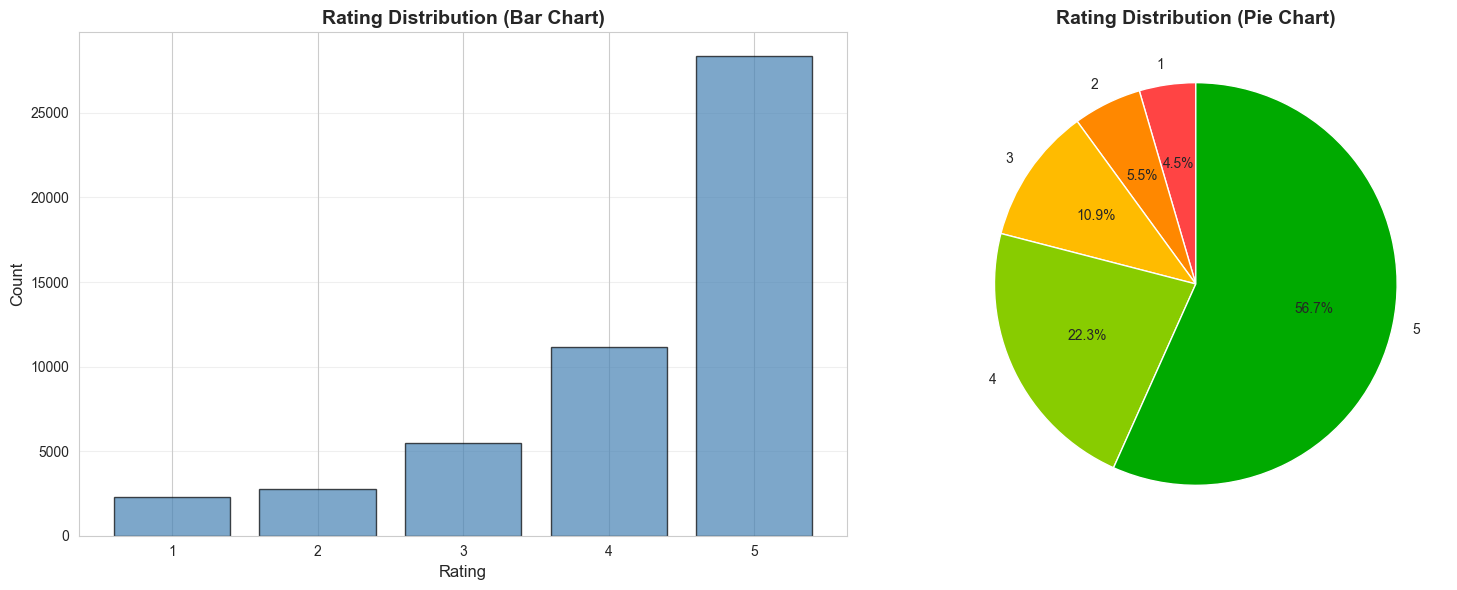


Rating Statistics:
Mean: 4.21
Median: 5.00
Mode: 5
Std Dev: 1.12


In [5]:
# Rating distribution - Multiple visualizations
if 'overall' in df_sample.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    rating_counts = df_sample['overall'].value_counts().sort_index()
    axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_title('Rating Distribution (Bar Chart)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Rating', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_xticks(rating_counts.index)
    
    # Pie chart
    colors = ['#ff4444', '#ff8800', '#ffbb00', '#88cc00', '#00aa00']
    axes[1].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%', 
                colors=colors[:len(rating_counts)], startangle=90)
    axes[1].set_title('Rating Distribution (Pie Chart)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rating_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Rating distribution statistics
    print(f"\nRating Statistics:")
    print(f"Mean: {df_sample['overall'].mean():.2f}")
    print(f"Median: {df_sample['overall'].median():.2f}")
    print(f"Mode: {df_sample['overall'].mode()[0]}")
    print(f"Std Dev: {df_sample['overall'].std():.2f}")


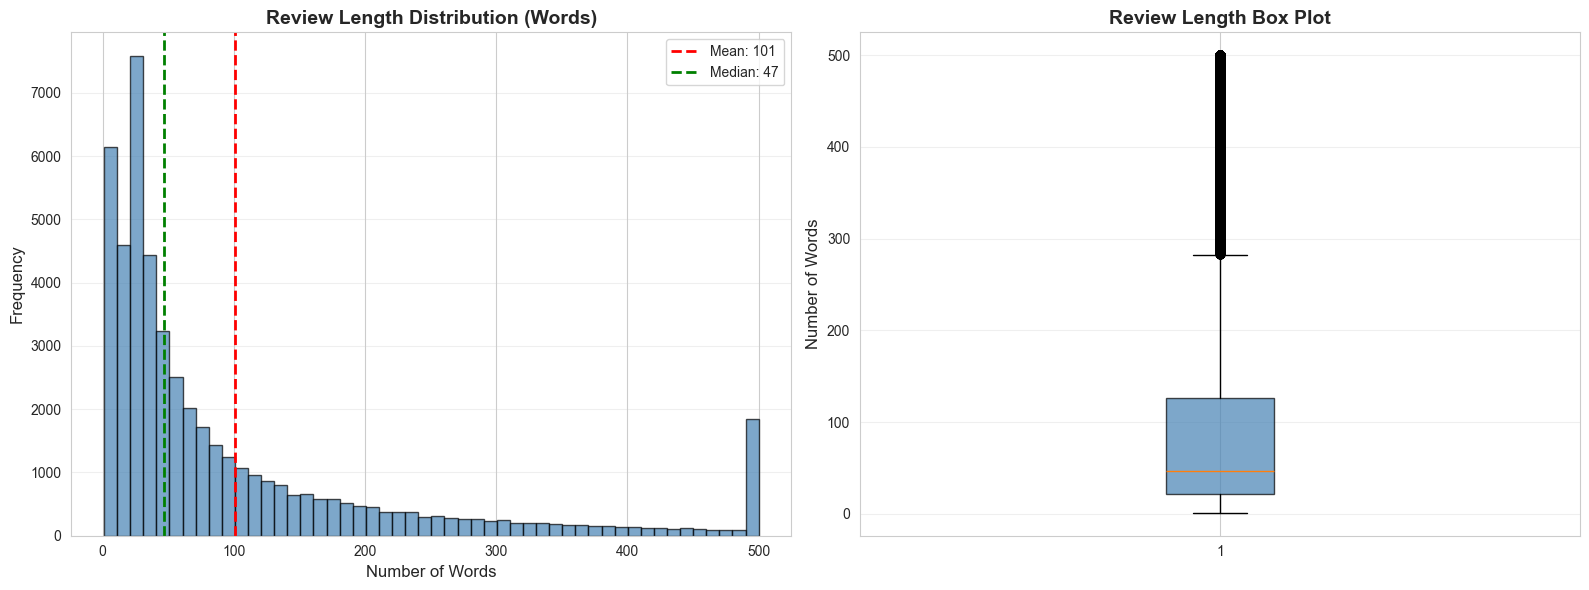


Review Length Statistics:
Mean: 110.6 words
Median: 47.0 words
Min: 1 words
Max: 5281 words
Q1: 22.0 words
Q3: 126.0 words


In [6]:
# Review length distribution - Enhanced visualization
if 'review_length_words' in df_sample.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram
    review_lengths = df_sample['review_length_words'].clip(upper=500)
    axes[0].hist(review_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(review_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {review_lengths.mean():.0f}')
    axes[0].axvline(review_lengths.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {review_lengths.median():.0f}')
    axes[0].set_title('Review Length Distribution (Words)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Number of Words', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot
    axes[1].boxplot(review_lengths, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.7))
    axes[1].set_title('Review Length Box Plot', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Number of Words', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'review_length_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print(f"\nReview Length Statistics:")
    print(f"Mean: {df_sample['review_length_words'].mean():.1f} words")
    print(f"Median: {df_sample['review_length_words'].median():.1f} words")
    print(f"Min: {df_sample['review_length_words'].min():.0f} words")
    print(f"Max: {df_sample['review_length_words'].max():.0f} words")
    print(f"Q1: {df_sample['review_length_words'].quantile(0.25):.1f} words")
    print(f"Q3: {df_sample['review_length_words'].quantile(0.75):.1f} words")


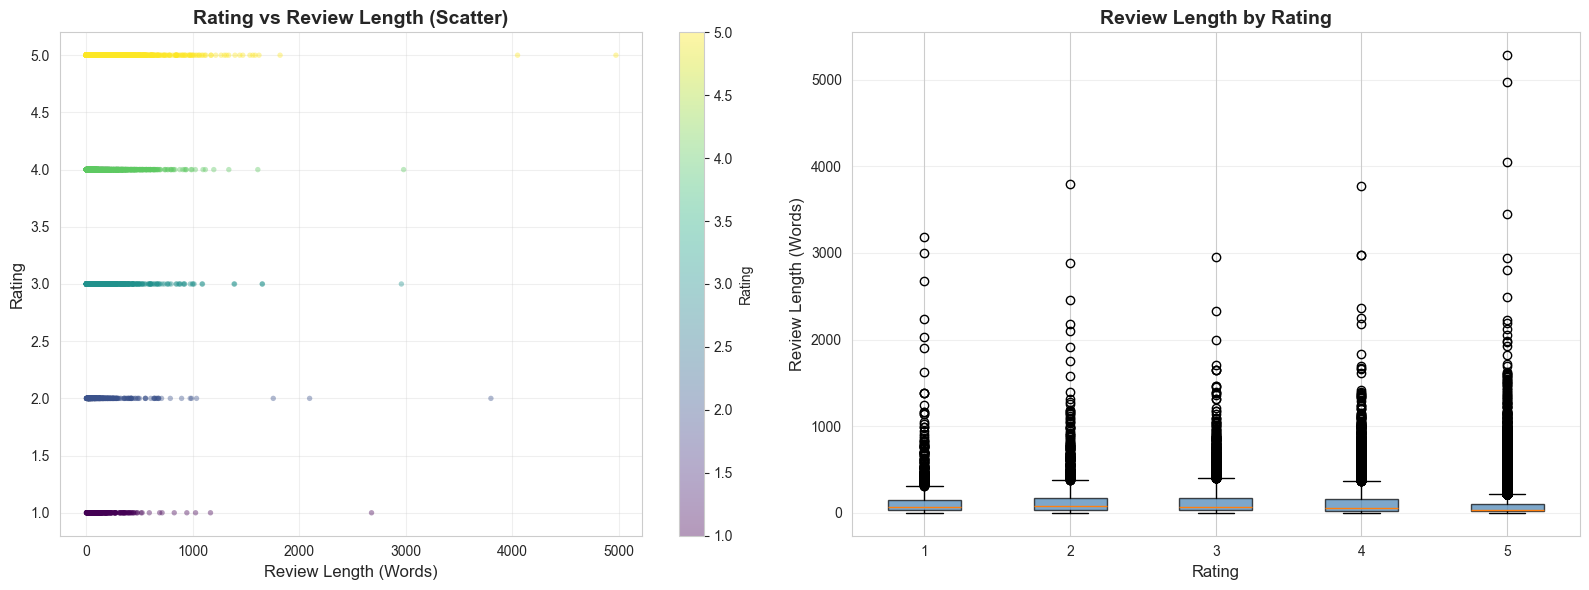


Correlation between Rating and Review Length: -0.094


In [7]:
# Rating vs Review Length - Enhanced analysis
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot with density
    plot_sample = df_sample.sample(n=min(10000, len(df_sample)), random_state=42)
    scatter = axes[0].scatter(plot_sample['review_length_words'], plot_sample['overall'], 
                              alpha=0.4, s=15, c=plot_sample['overall'], 
                              cmap='viridis', edgecolors='none')
    axes[0].set_title('Rating vs Review Length (Scatter)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Review Length (Words)', fontsize=12)
    axes[0].set_ylabel('Rating', fontsize=12)
    axes[0].grid(alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='Rating')
    
    # Box plot by rating
    rating_groups = [df_sample[df_sample['overall'] == rating]['review_length_words'].values 
                     for rating in sorted(df_sample['overall'].unique())]
    bp = axes[1].boxplot(rating_groups, labels=sorted(df_sample['overall'].unique()),
                         patch_artist=True, vert=True)
    for patch in bp['boxes']:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.7)
    axes[1].set_title('Review Length by Rating', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Rating', fontsize=12)
    axes[1].set_ylabel('Review Length (Words)', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rating_vs_length.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correlation
    corr = df_sample[['overall', 'review_length_words']].corr().iloc[0, 1]
    print(f"\nCorrelation between Rating and Review Length: {corr:.3f}")


## 5.1 Additional Visualizations


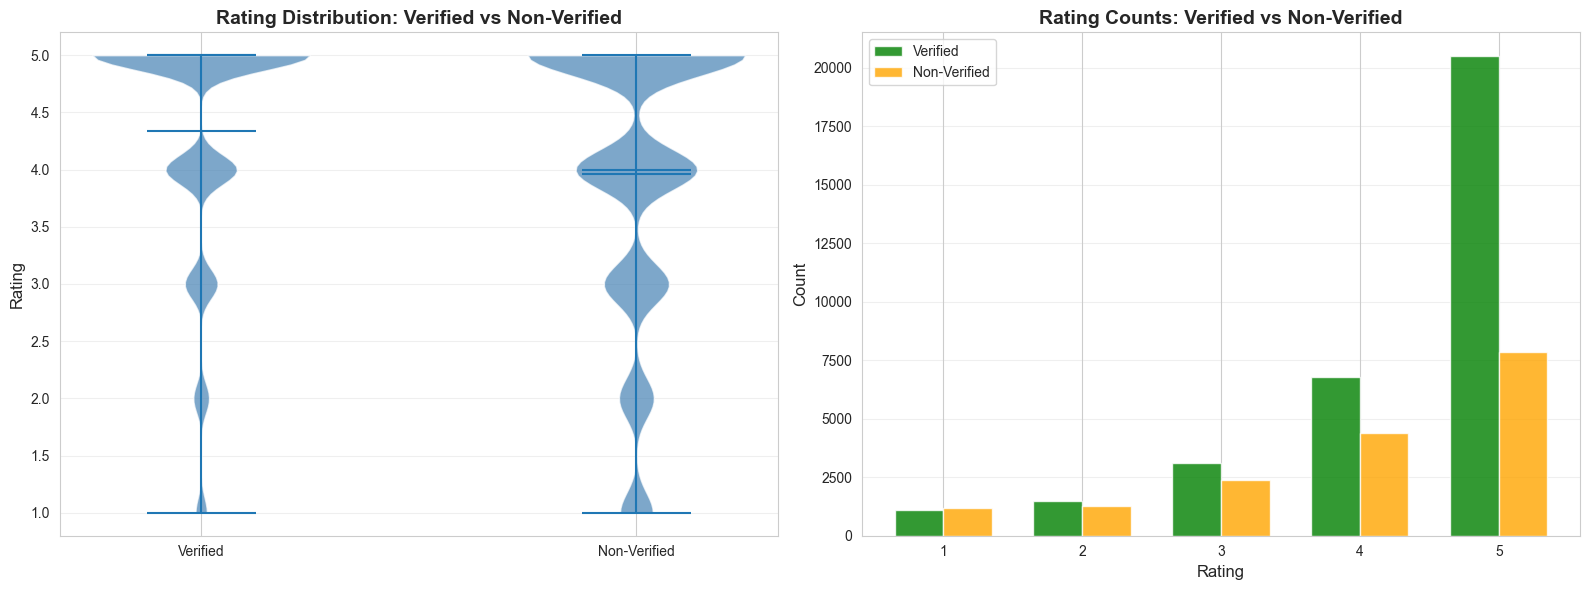


Verified Purchase Statistics:
  Mean Rating: 4.34
  Median Rating: 5.00
  Count: 32,939

Non-Verified Purchase Statistics:
  Mean Rating: 3.97
  Median Rating: 4.00
  Count: 17,061


In [8]:
# Verified vs Non-Verified Purchase Comparison
if 'is_verified' in df_sample.columns and 'overall' in df_sample.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Rating distribution comparison
    verified_ratings = df_sample[df_sample['is_verified'] == True]['overall']
    non_verified_ratings = df_sample[df_sample['is_verified'] == False]['overall']
    
    # Violin plot
    data_to_plot = [verified_ratings.values, non_verified_ratings.values]
    parts = axes[0].violinplot(data_to_plot, positions=[1, 2], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor('steelblue')
        pc.set_alpha(0.7)
    axes[0].set_xticks([1, 2])
    axes[0].set_xticklabels(['Verified', 'Non-Verified'])
    axes[0].set_ylabel('Rating', fontsize=12)
    axes[0].set_title('Rating Distribution: Verified vs Non-Verified', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Side-by-side bar chart
    verified_counts = verified_ratings.value_counts().sort_index()
    non_verified_counts = non_verified_ratings.value_counts().sort_index()
    x = np.arange(len(verified_counts))
    width = 0.35
    
    axes[1].bar(x - width/2, verified_counts.values, width, label='Verified', alpha=0.8, color='green')
    axes[1].bar(x + width/2, non_verified_counts.values, width, label='Non-Verified', alpha=0.8, color='orange')
    axes[1].set_xlabel('Rating', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Rating Counts: Verified vs Non-Verified', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(verified_counts.index)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'verified_vs_nonverified.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVerified Purchase Statistics:")
    print(f"  Mean Rating: {verified_ratings.mean():.2f}")
    print(f"  Median Rating: {verified_ratings.median():.2f}")
    print(f"  Count: {len(verified_ratings):,}")
    print(f"\nNon-Verified Purchase Statistics:")
    print(f"  Mean Rating: {non_verified_ratings.mean():.2f}")
    print(f"  Median Rating: {non_verified_ratings.median():.2f}")
    print(f"  Count: {len(non_verified_ratings):,}")


In [ ]:
# Product-level Analysis (if product ID available)
product_cols = [col for col in df_sample.columns if 'product' in col.lower() or 'asin' in col.lower()]

if product_cols and 'overall' in df_sample.columns:
    product_col = product_cols[0]
    print(f"Analyzing products using column: {product_col}")
    
    # Top products by review count
    top_products = df_sample[product_col].value_counts().head(10)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top 10 products by review count
    axes[0, 0].barh(range(len(top_products)), top_products.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_yticks(range(len(top_products)))
    axes[0, 0].set_yticklabels([f"Product {i+1}" for i in range(len(top_products))])
    axes[0, 0].set_xlabel('Number of Reviews', fontsize=12)
    axes[0, 0].set_title('Top 10 Products by Review Count', fontsize=14, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Average rating by product (top 10)
    top_product_ids = top_products.index[:10]
    avg_ratings = df_sample[df_sample[product_col].isin(top_product_ids)].groupby(product_col)['overall'].mean().sort_values(ascending=False)
    axes[0, 1].barh(range(len(avg_ratings)), avg_ratings.values, color='coral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(avg_ratings)))
    axes[0, 1].set_yticklabels([f"Product {i+1}" for i in range(len(avg_ratings))])
    axes[0, 1].set_xlabel('Average Rating', fontsize=12)
    axes[0, 1].set_title('Average Rating for Top 10 Products', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim([0, 5])
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Review count distribution
    review_counts_per_product = df_sample[product_col].value_counts()
    axes[1, 0].hist(review_counts_per_product.values, bins=50, color='steelblue', 
                    edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Distribution of Reviews per Product', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Reviews', fontsize=12)
    axes[1, 0].set_ylabel('Number of Products', fontsize=12)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Average rating distribution across products
    avg_ratings_all = df_sample.groupby(product_col)['overall'].mean()
    axes[1, 1].hist(avg_ratings_all.values, bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(avg_ratings_all.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {avg_ratings_all.mean():.2f}')
    axes[1, 1].set_title('Distribution of Average Ratings per Product', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Average Rating', fontsize=12)
    axes[1, 1].set_ylabel('Number of Products', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'product_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nProduct Statistics:")
    print(f"  Total unique products: {df_sample[product_col].nunique():,}")
    print(f"  Average reviews per product: {review_counts_per_product.mean():.1f}")
    print(f"  Median reviews per product: {review_counts_per_product.median():.1f}")
    print(f"  Average rating across all products: {avg_ratings_all.mean():.2f}")
else:
    print("Product ID column not found. Skipping product-level analysis.")


## 5.2 Advanced Statistical Visualizations


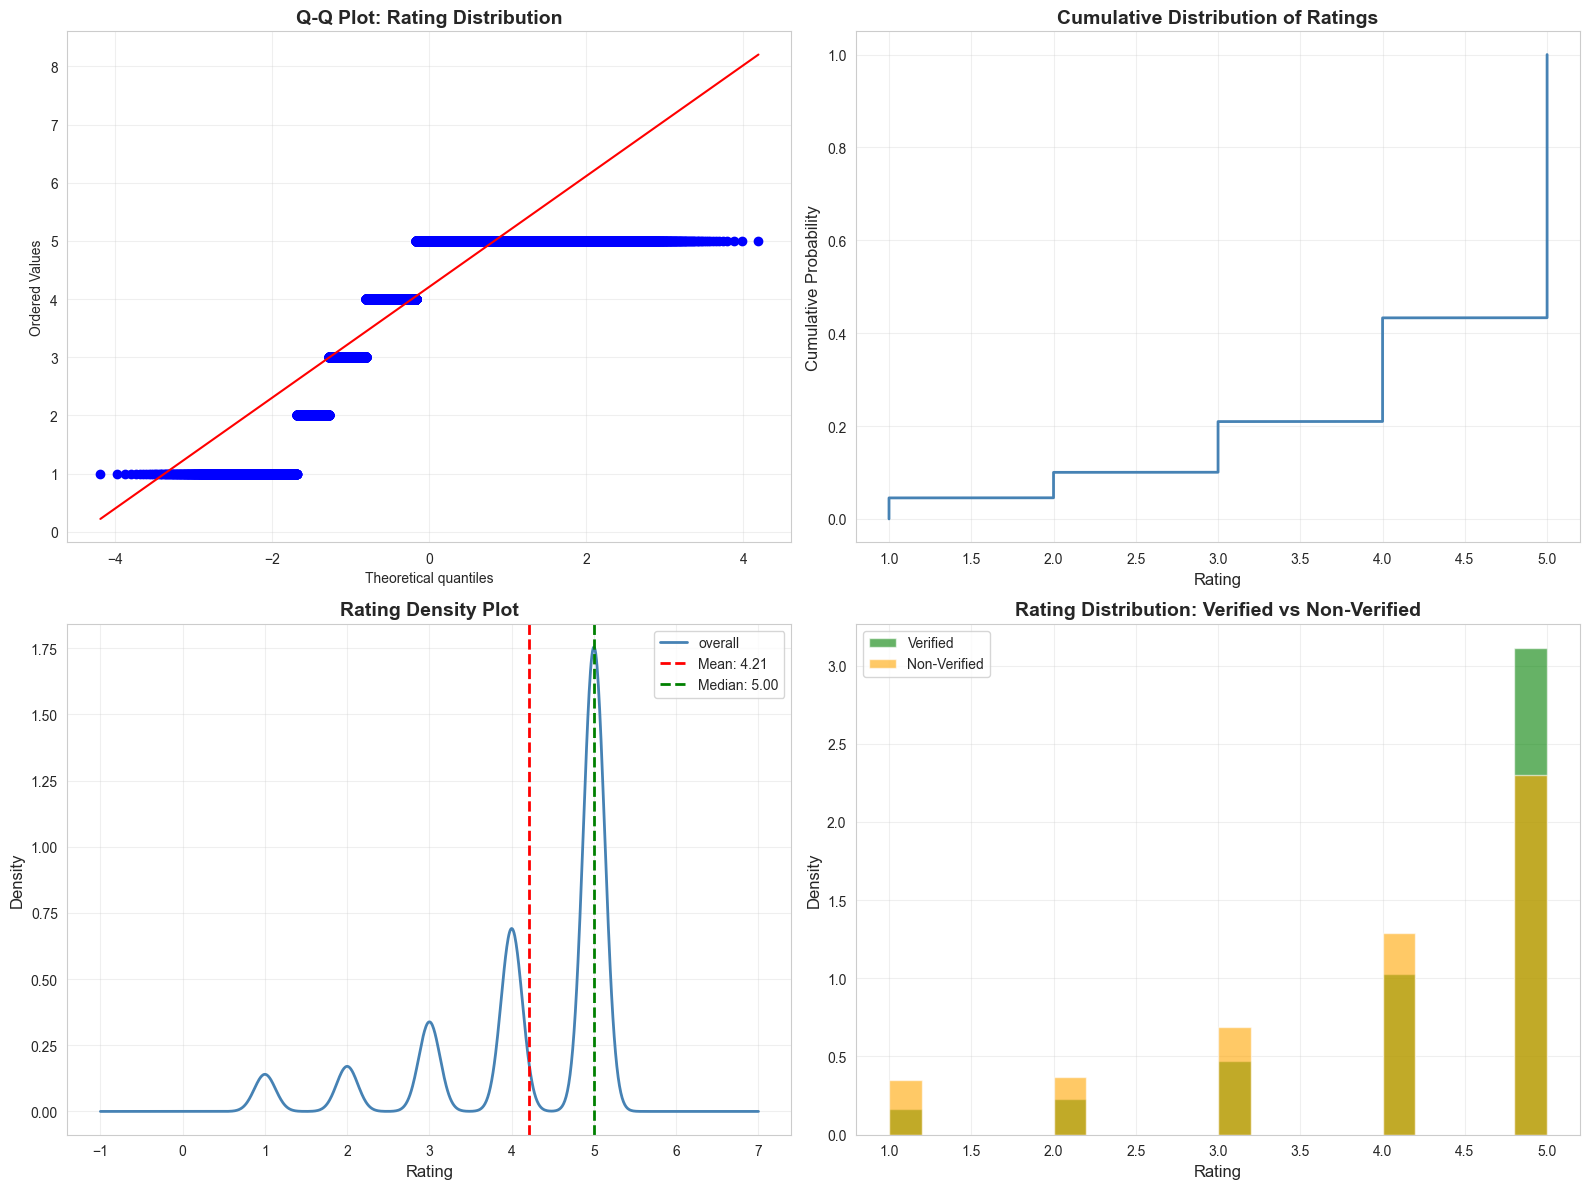

In [10]:
# Distribution comparison plots
if 'overall' in df_sample.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Q-Q plot for rating distribution (checking normality)
    from scipy import stats
    stats.probplot(df_sample['overall'], dist="norm", plot=axes[0, 0])
    axes[0, 0].set_title('Q-Q Plot: Rating Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    
    # Cumulative distribution
    sorted_ratings = np.sort(df_sample['overall'])
    y_vals = np.arange(1, len(sorted_ratings) + 1) / len(sorted_ratings)
    axes[0, 1].plot(sorted_ratings, y_vals, linewidth=2, color='steelblue')
    axes[0, 1].set_title('Cumulative Distribution of Ratings', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Rating', fontsize=12)
    axes[0, 1].set_ylabel('Cumulative Probability', fontsize=12)
    axes[0, 1].grid(alpha=0.3)
    
    # Density plot
    df_sample['overall'].plot(kind='density', ax=axes[1, 0], color='steelblue', linewidth=2)
    axes[1, 0].axvline(df_sample['overall'].mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {df_sample["overall"].mean():.2f}')
    axes[1, 0].axvline(df_sample['overall'].median(), color='green', linestyle='--', 
                       linewidth=2, label=f'Median: {df_sample["overall"].median():.2f}')
    axes[1, 0].set_title('Rating Density Plot', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Rating', fontsize=12)
    axes[1, 0].set_ylabel('Density', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Rating by category (if verified status available)
    if 'is_verified' in df_sample.columns:
        verified_data = df_sample[df_sample['is_verified'] == True]['overall']
        non_verified_data = df_sample[df_sample['is_verified'] == False]['overall']
        
        axes[1, 1].hist(verified_data, bins=20, alpha=0.6, label='Verified', color='green', density=True)
        axes[1, 1].hist(non_verified_data, bins=20, alpha=0.6, label='Non-Verified', color='orange', density=True)
        axes[1, 1].set_title('Rating Distribution: Verified vs Non-Verified', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Rating', fontsize=12)
        axes[1, 1].set_ylabel('Density', fontsize=12)
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Verified status not available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Rating Distribution Comparison', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'advanced_statistical_plots.png', dpi=300, bbox_inches='tight')
    plt.show()


## 5.3 Comprehensive Distribution Analysis


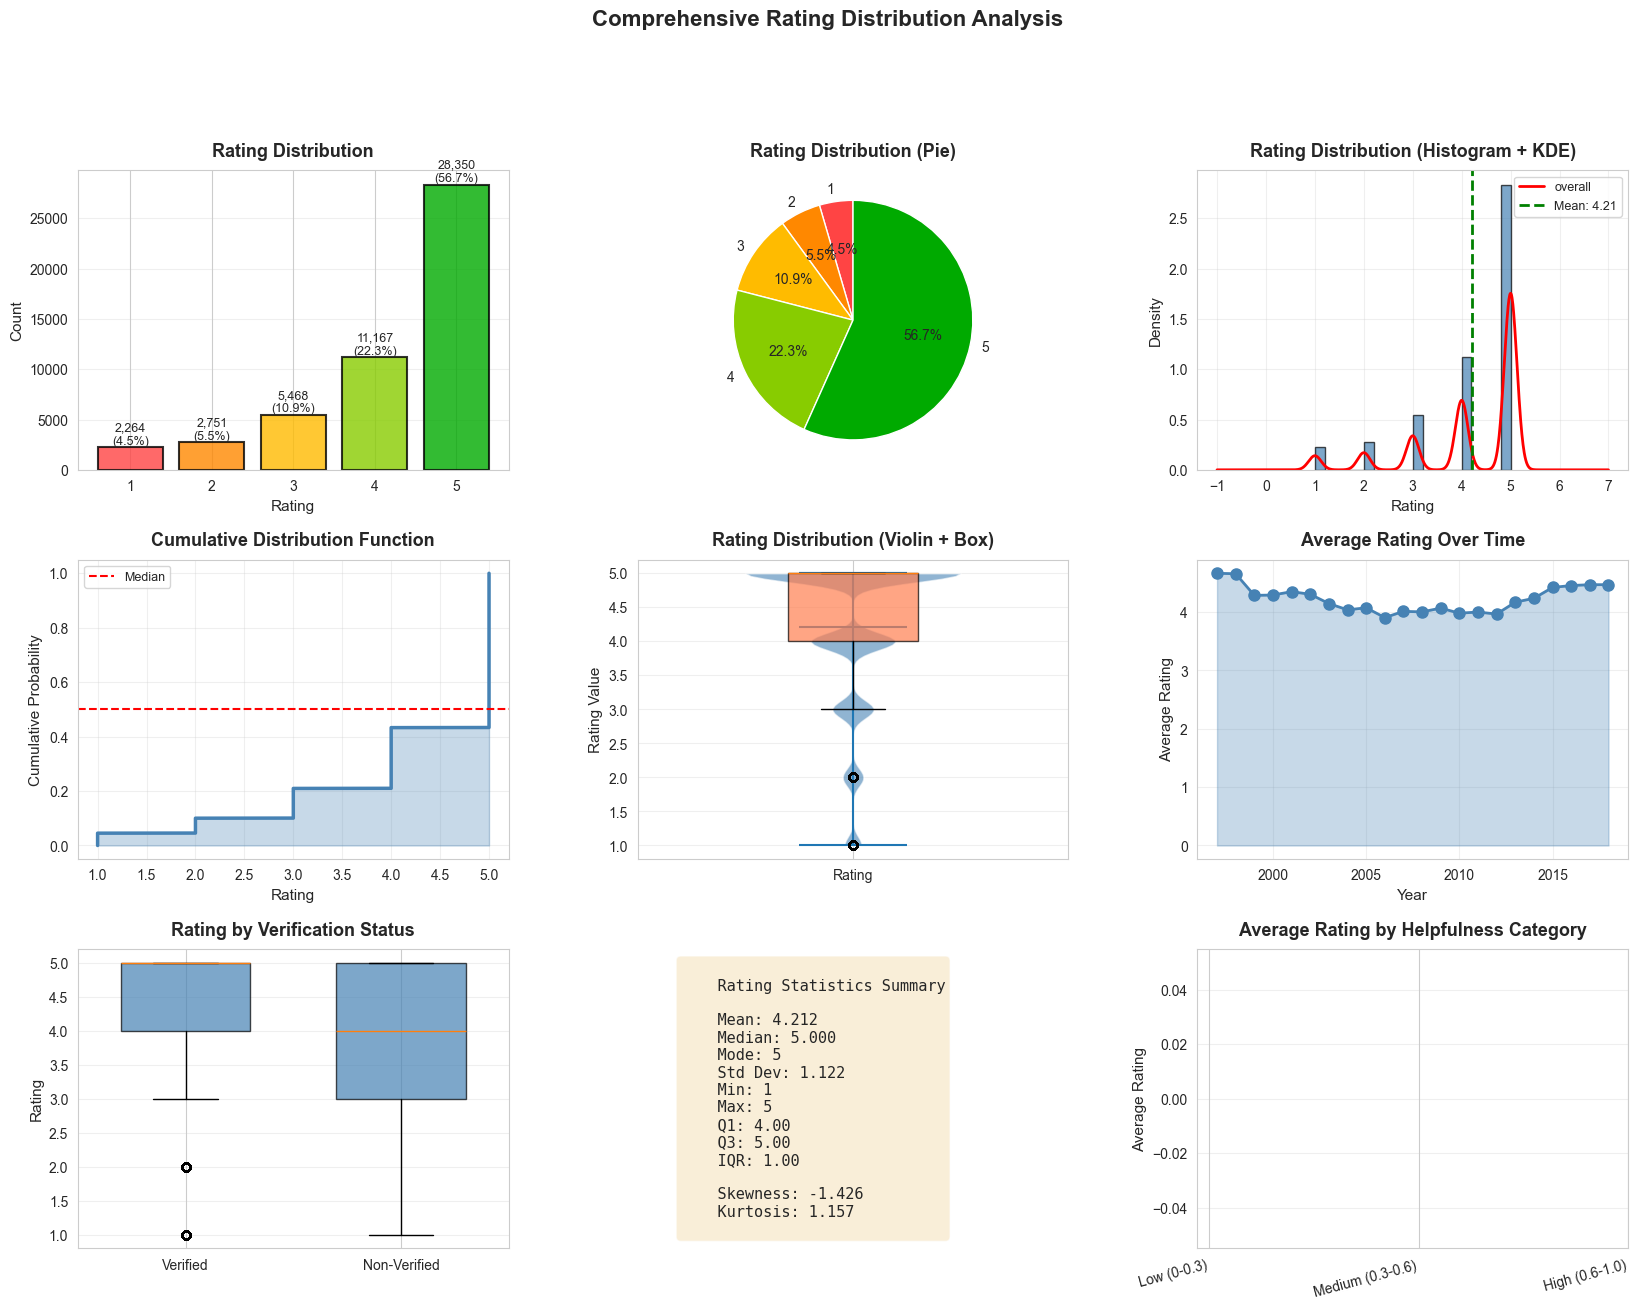

In [11]:
# Comprehensive distribution analysis with multiple visualizations
if 'overall' in df_sample.columns:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Rating distribution - Bar chart with percentages
    ax1 = fig.add_subplot(gs[0, 0])
    rating_counts = df_sample['overall'].value_counts().sort_index()
    bars = ax1.bar(rating_counts.index, rating_counts.values, 
                   color=['#ff4444', '#ff8800', '#ffbb00', '#88cc00', '#00aa00'][:len(rating_counts)],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_title('Rating Distribution', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xlabel('Rating', fontsize=11)
    ax1.set_ylabel('Count', fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    # Add percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/len(df_sample)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)
    
    # 2. Rating distribution - Pie chart
    ax2 = fig.add_subplot(gs[0, 1])
    colors = ['#ff4444', '#ff8800', '#ffbb00', '#88cc00', '#00aa00']
    wedges, texts, autotexts = ax2.pie(rating_counts.values, labels=rating_counts.index, 
                                        autopct='%1.1f%%', colors=colors[:len(rating_counts)],
                                        startangle=90, textprops={'fontsize': 10})
    ax2.set_title('Rating Distribution (Pie)', fontsize=13, fontweight='bold', pad=10)
    
    # 3. Rating distribution - Histogram with KDE
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(df_sample['overall'], bins=20, color='steelblue', alpha=0.7, 
             edgecolor='black', density=True)
    df_sample['overall'].plot(kind='kde', ax=ax3, color='red', linewidth=2)
    ax3.axvline(df_sample['overall'].mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {df_sample["overall"].mean():.2f}')
    ax3.set_title('Rating Distribution (Histogram + KDE)', fontsize=13, fontweight='bold', pad=10)
    ax3.set_xlabel('Rating', fontsize=11)
    ax3.set_ylabel('Density', fontsize=11)
    ax3.legend(fontsize=9)
    ax3.grid(alpha=0.3)
    
    # 4. Cumulative distribution
    ax4 = fig.add_subplot(gs[1, 0])
    sorted_ratings = np.sort(df_sample['overall'])
    y_vals = np.arange(1, len(sorted_ratings) + 1) / len(sorted_ratings)
    ax4.plot(sorted_ratings, y_vals, linewidth=2.5, color='steelblue')
    ax4.fill_between(sorted_ratings, y_vals, alpha=0.3, color='steelblue')
    ax4.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label='Median')
    ax4.set_title('Cumulative Distribution Function', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xlabel('Rating', fontsize=11)
    ax4.set_ylabel('Cumulative Probability', fontsize=11)
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    
    # 5. Box plot with violin plot overlay
    ax5 = fig.add_subplot(gs[1, 1])
    parts = ax5.violinplot([df_sample['overall']], positions=[1], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor('steelblue')
        pc.set_alpha(0.6)
    bp = ax5.boxplot([df_sample['overall']], positions=[1], widths=0.3, patch_artist=True)
    bp['boxes'][0].set_facecolor('coral')
    bp['boxes'][0].set_alpha(0.7)
    ax5.set_xticks([1])
    ax5.set_xticklabels(['Rating'])
    ax5.set_ylabel('Rating Value', fontsize=11)
    ax5.set_title('Rating Distribution (Violin + Box)', fontsize=13, fontweight='bold', pad=10)
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Rating over time (if datetime available)
    ax6 = fig.add_subplot(gs[1, 2])
    if 'review_datetime' in df_sample.columns:
        df_sample['review_datetime'] = pd.to_datetime(df_sample['review_datetime'], errors='coerce')
        df_sample['review_year'] = df_sample['review_datetime'].dt.year
        yearly_avg = df_sample.groupby('review_year')['overall'].mean()
        ax6.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, 
                markersize=8, color='steelblue')
        ax6.fill_between(yearly_avg.index, yearly_avg.values, alpha=0.3, color='steelblue')
        ax6.set_title('Average Rating Over Time', fontsize=13, fontweight='bold', pad=10)
        ax6.set_xlabel('Year', fontsize=11)
        ax6.set_ylabel('Average Rating', fontsize=11)
        ax6.grid(alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Temporal data not available', 
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('Average Rating Over Time', fontsize=13, fontweight='bold', pad=10)
    
    # 7. Rating by verification status
    if 'is_verified' in df_sample.columns:
        ax7 = fig.add_subplot(gs[2, 0])
        verified_ratings = df_sample[df_sample['is_verified'] == True]['overall']
        non_verified_ratings = df_sample[df_sample['is_verified'] == False]['overall']
        
        data_to_plot = [verified_ratings.values, non_verified_ratings.values]
        bp = ax7.boxplot(data_to_plot, labels=['Verified', 'Non-Verified'], 
                        patch_artist=True, widths=0.6)
        for patch in bp['boxes']:
            patch.set_facecolor('steelblue')
            patch.set_alpha(0.7)
        ax7.set_ylabel('Rating', fontsize=11)
        ax7.set_title('Rating by Verification Status', fontsize=13, fontweight='bold', pad=10)
        ax7.grid(axis='y', alpha=0.3)
    
    # 8. Rating statistics summary
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.axis('off')
    stats_text = f"""
    Rating Statistics Summary
    
    Mean: {df_sample['overall'].mean():.3f}
    Median: {df_sample['overall'].median():.3f}
    Mode: {df_sample['overall'].mode()[0]}
    Std Dev: {df_sample['overall'].std():.3f}
    Min: {df_sample['overall'].min():.0f}
    Max: {df_sample['overall'].max():.0f}
    Q1: {df_sample['overall'].quantile(0.25):.2f}
    Q3: {df_sample['overall'].quantile(0.75):.2f}
    IQR: {df_sample['overall'].quantile(0.75) - df_sample['overall'].quantile(0.25):.2f}
    
    Skewness: {df_sample['overall'].skew():.3f}
    Kurtosis: {df_sample['overall'].kurtosis():.3f}
    """
    ax8.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 9. Rating distribution by categories (if helpfulness available)
    ax9 = fig.add_subplot(gs[2, 2])
    if 'helpfulness_ratio' in df_sample.columns:
        df_sample['helpfulness_cat'] = pd.cut(df_sample['helpfulness_ratio'], 
                                              bins=[0, 0.3, 0.6, 1.0],
                                              labels=['Low (0-0.3)', 'Medium (0.3-0.6)', 'High (0.6-1.0)'])
        helpful_cat_ratings = df_sample.groupby('helpfulness_cat')['overall'].mean()
        bars = ax9.bar(range(len(helpful_cat_ratings)), helpful_cat_ratings.values,
                      color=['#ff4444', '#ffbb00', '#00aa00'], alpha=0.7, edgecolor='black')
        ax9.set_xticks(range(len(helpful_cat_ratings)))
        ax9.set_xticklabels(helpful_cat_ratings.index, rotation=15, ha='right')
        ax9.set_ylabel('Average Rating', fontsize=11)
        ax9.set_title('Average Rating by Helpfulness Category', fontsize=13, fontweight='bold', pad=10)
        ax9.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    else:
        ax9.text(0.5, 0.5, 'Helpfulness data not available', 
                ha='center', va='center', transform=ax9.transAxes, fontsize=12)
        ax9.set_title('Rating by Helpfulness', fontsize=13, fontweight='bold', pad=10)
    
    plt.suptitle('Comprehensive Rating Distribution Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(FIGURES_DIR / 'comprehensive_rating_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


## 5.4 Review Text Analysis Visualizations


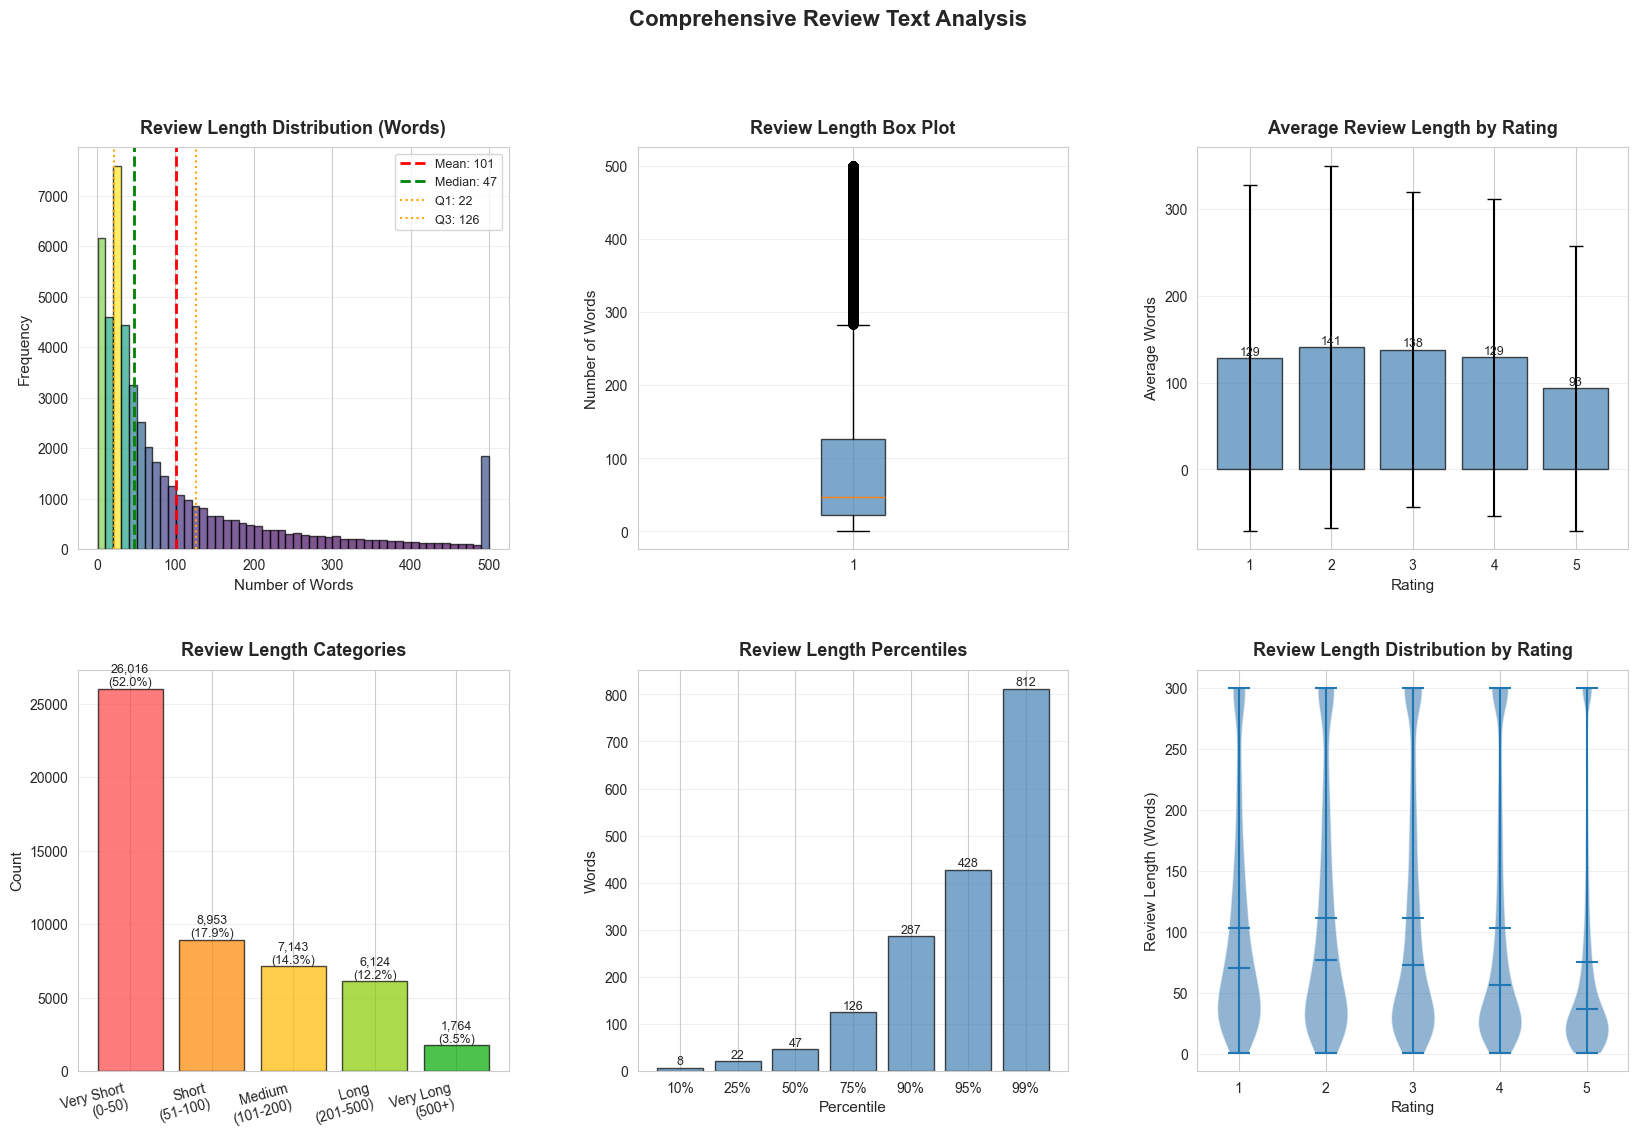


Review Length Statistics:
  Mean: 110.6 words
  Median: 47.0 words
  Std Dev: 175.9 words
  Min: 1 words
  Max: 5281 words
  Q1: 22.0 words
  Q3: 126.0 words
  IQR: 104.0 words
  Skewness: 5.576
  Kurtosis: 71.553


In [12]:
# Comprehensive review text analysis
if 'review_length_words' in df_sample.columns:
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Clip extreme values for better visualization
    review_lengths = df_sample['review_length_words'].clip(upper=500)
    
    # 1. Histogram with multiple statistics
    ax1 = fig.add_subplot(gs[0, 0])
    n, bins, patches = ax1.hist(review_lengths, bins=50, color='steelblue', 
                                edgecolor='black', alpha=0.7)
    # Color bars by density
    for i, patch in enumerate(patches):
        patch.set_facecolor(plt.cm.viridis(n[i]/max(n)))
    ax1.axvline(review_lengths.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {review_lengths.mean():.0f}')
    ax1.axvline(review_lengths.median(), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {review_lengths.median():.0f}')
    ax1.axvline(review_lengths.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, 
               label=f'Q1: {review_lengths.quantile(0.25):.0f}')
    ax1.axvline(review_lengths.quantile(0.75), color='orange', linestyle=':', linewidth=1.5, 
               label=f'Q3: {review_lengths.quantile(0.75):.0f}')
    ax1.set_title('Review Length Distribution (Words)', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xlabel('Number of Words', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Box plot with outliers
    ax2 = fig.add_subplot(gs[0, 1])
    bp = ax2.boxplot(review_lengths, vert=True, patch_artist=True, 
                    boxprops=dict(facecolor='steelblue', alpha=0.7),
                    showfliers=True)
    ax2.set_title('Review Length Box Plot', fontsize=13, fontweight='bold', pad=10)
    ax2.set_ylabel('Number of Words', fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Review length by rating
    if 'overall' in df_sample.columns:
        ax3 = fig.add_subplot(gs[0, 2])
        avg_length_by_rating = df_sample.groupby('overall')['review_length_words'].mean()
        std_length_by_rating = df_sample.groupby('overall')['review_length_words'].std()
        
        bars = ax3.bar(avg_length_by_rating.index, avg_length_by_rating.values,
                      yerr=std_length_by_rating.values, capsize=5,
                      color='steelblue', alpha=0.7, edgecolor='black')
        ax3.set_title('Average Review Length by Rating', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xlabel('Rating', fontsize=11)
        ax3.set_ylabel('Average Words', fontsize=11)
        ax3.grid(axis='y', alpha=0.3)
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Review length categories distribution
    ax4 = fig.add_subplot(gs[1, 0])
    df_sample['length_category'] = pd.cut(df_sample['review_length_words'], 
                                          bins=[0, 50, 100, 200, 500, float('inf')],
                                          labels=['Very Short\n(0-50)', 'Short\n(51-100)', 
                                                 'Medium\n(101-200)', 'Long\n(201-500)', 
                                                 'Very Long\n(500+)'])
    length_cat_counts = df_sample['length_category'].value_counts().sort_index()
    colors_cat = ['#ff4444', '#ff8800', '#ffbb00', '#88cc00', '#00aa00']
    bars = ax4.bar(range(len(length_cat_counts)), length_cat_counts.values,
                  color=colors_cat[:len(length_cat_counts)], alpha=0.7, edgecolor='black')
    ax4.set_xticks(range(len(length_cat_counts)))
    ax4.set_xticklabels(length_cat_counts.index, rotation=15, ha='right')
    ax4.set_title('Review Length Categories', fontsize=13, fontweight='bold', pad=10)
    ax4.set_ylabel('Count', fontsize=11)
    ax4.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/len(df_sample)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)
    
    # 5. Review length percentiles
    ax5 = fig.add_subplot(gs[1, 1])
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    length_percentiles = [df_sample['review_length_words'].quantile(p/100) for p in percentiles]
    bars = ax5.bar(range(len(percentiles)), length_percentiles, 
                  color='steelblue', alpha=0.7, edgecolor='black')
    ax5.set_xticks(range(len(percentiles)))
    ax5.set_xticklabels([f'{p}%' for p in percentiles])
    ax5.set_title('Review Length Percentiles', fontsize=13, fontweight='bold', pad=10)
    ax5.set_xlabel('Percentile', fontsize=11)
    ax5.set_ylabel('Words', fontsize=11)
    ax5.grid(axis='y', alpha=0.3)
    for i, (bar, val) in enumerate(zip(bars, length_percentiles)):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 6. Review length distribution by rating (violin plot)
    if 'overall' in df_sample.columns:
        ax6 = fig.add_subplot(gs[1, 2])
        rating_groups = [df_sample[df_sample['overall'] == rating]['review_length_words'].clip(upper=300).values 
                        for rating in sorted(df_sample['overall'].unique())]
        parts = ax6.violinplot(rating_groups, positions=range(len(rating_groups)),
                              showmeans=True, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor('steelblue')
            pc.set_alpha(0.6)
        ax6.set_xticks(range(len(rating_groups)))
        ax6.set_xticklabels(sorted(df_sample['overall'].unique()))
        ax6.set_title('Review Length Distribution by Rating', fontsize=13, fontweight='bold', pad=10)
        ax6.set_xlabel('Rating', fontsize=11)
        ax6.set_ylabel('Review Length (Words)', fontsize=11)
        ax6.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Comprehensive Review Text Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(FIGURES_DIR / 'comprehensive_review_text_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print(f"\nReview Length Statistics:")
    print(f"  Mean: {df_sample['review_length_words'].mean():.1f} words")
    print(f"  Median: {df_sample['review_length_words'].median():.1f} words")
    print(f"  Std Dev: {df_sample['review_length_words'].std():.1f} words")
    print(f"  Min: {df_sample['review_length_words'].min():.0f} words")
    print(f"  Max: {df_sample['review_length_words'].max():.0f} words")
    print(f"  Q1: {df_sample['review_length_words'].quantile(0.25):.1f} words")
    print(f"  Q3: {df_sample['review_length_words'].quantile(0.75):.1f} words")
    print(f"  IQR: {df_sample['review_length_words'].quantile(0.75) - df_sample['review_length_words'].quantile(0.25):.1f} words")
    print(f"  Skewness: {df_sample['review_length_words'].skew():.3f}")
    print(f"  Kurtosis: {df_sample['review_length_words'].kurtosis():.3f}")


## 5.5 Relationship Analysis - Multi-dimensional Visualizations


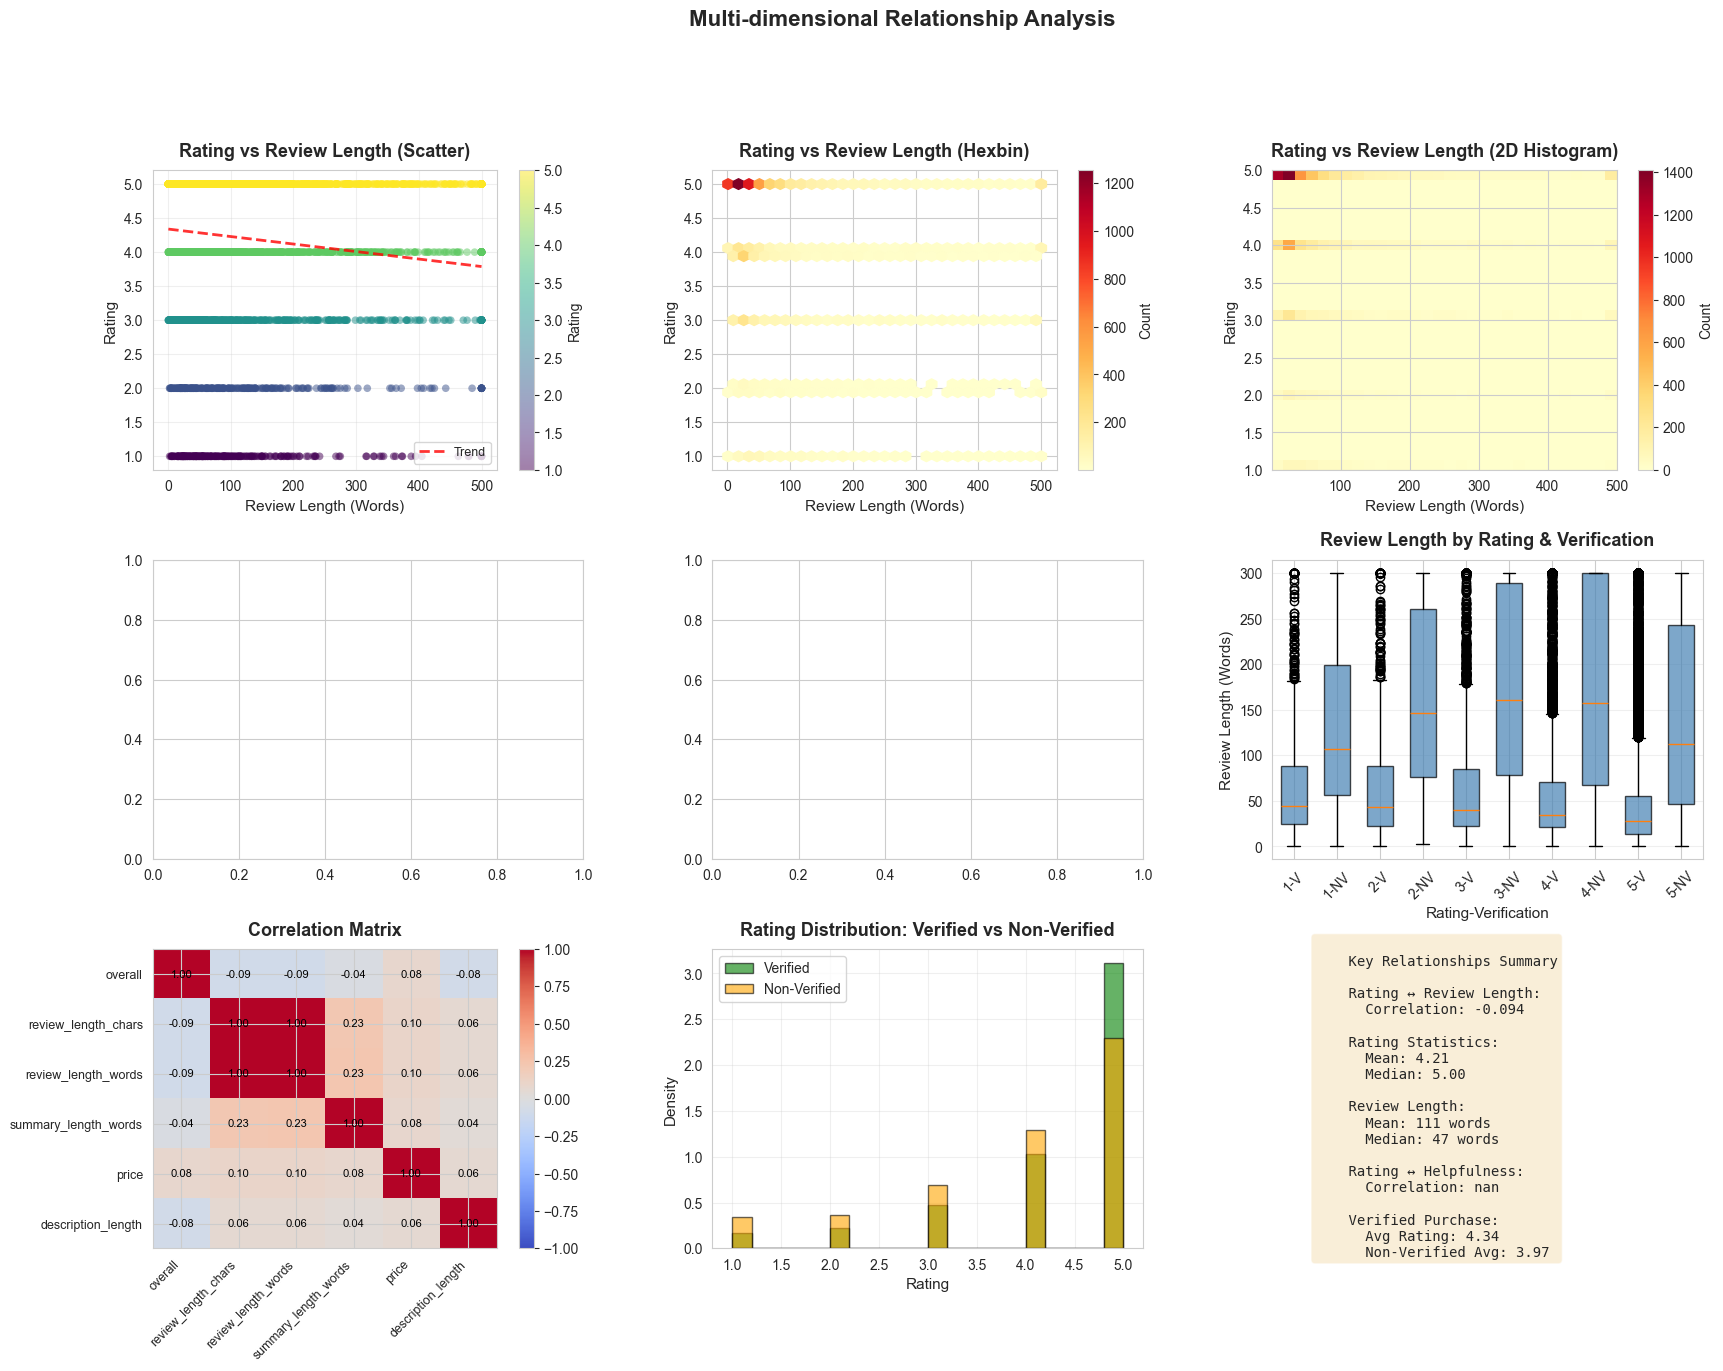

In [13]:
# Multi-dimensional relationship analysis
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Rating vs Review Length - Enhanced scatter
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    ax1 = fig.add_subplot(gs[0, 0])
    plot_sample = df_sample.sample(n=min(5000, len(df_sample)), random_state=42)
    scatter = ax1.scatter(plot_sample['review_length_words'].clip(upper=500), 
                         plot_sample['overall'],
                         alpha=0.5, s=30, c=plot_sample['overall'], 
                         cmap='viridis', edgecolors='none')
    ax1.set_title('Rating vs Review Length (Scatter)', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xlabel('Review Length (Words)', fontsize=11)
    ax1.set_ylabel('Rating', fontsize=11)
    ax1.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Rating')
    
    # Add trend line
    z = np.polyfit(plot_sample['review_length_words'].clip(upper=500), 
                   plot_sample['overall'], 1)
    p = np.poly1d(z)
    ax1.plot(plot_sample['review_length_words'].clip(upper=500).sort_values(),
            p(plot_sample['review_length_words'].clip(upper=500).sort_values()),
            "r--", alpha=0.8, linewidth=2, label='Trend')
    ax1.legend(fontsize=9)

# 2. Rating vs Review Length - Hexbin
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    ax2 = fig.add_subplot(gs[0, 1])
    plot_sample = df_sample.sample(n=min(10000, len(df_sample)), random_state=42)
    hb = ax2.hexbin(plot_sample['review_length_words'].clip(upper=500), 
                   plot_sample['overall'],
                   gridsize=30, cmap='YlOrRd', mincnt=1)
    ax2.set_title('Rating vs Review Length (Hexbin)', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xlabel('Review Length (Words)', fontsize=11)
    ax2.set_ylabel('Rating', fontsize=11)
    plt.colorbar(hb, ax=ax2, label='Count')

# 3. Rating vs Review Length - 2D Histogram
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    ax3 = fig.add_subplot(gs[0, 2])
    plot_sample = df_sample.sample(n=min(10000, len(df_sample)), random_state=42)
    hist, xedges, yedges = np.histogram2d(plot_sample['review_length_words'].clip(upper=500),
                                          plot_sample['overall'], bins=30)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax3.imshow(hist.T, origin='lower', extent=extent, cmap='YlOrRd', aspect='auto')
    ax3.set_title('Rating vs Review Length (2D Histogram)', fontsize=13, fontweight='bold', pad=10)
    ax3.set_xlabel('Review Length (Words)', fontsize=11)
    ax3.set_ylabel('Rating', fontsize=11)
    plt.colorbar(im, ax=ax3, label='Count')

# 4. Helpfulness vs Rating
if 'helpfulness_ratio' in df_sample.columns and 'overall' in df_sample.columns:
    ax4 = fig.add_subplot(gs[1, 0])
    helpful_sample = df_sample[df_sample['helpfulness_ratio'].notna()].sample(
        n=min(5000, len(df_sample[df_sample['helpfulness_ratio'].notna()])), random_state=42)
    if len(helpful_sample) > 0:
        scatter = ax4.scatter(helpful_sample['helpfulness_ratio'], 
                             helpful_sample['overall'],
                             alpha=0.5, s=30, c=helpful_sample['overall'], 
                             cmap='coolwarm', edgecolors='none')
        ax4.set_title('Helpfulness vs Rating', fontsize=13, fontweight='bold', pad=10)
        ax4.set_xlabel('Helpfulness Ratio', fontsize=11)
        ax4.set_ylabel('Rating', fontsize=11)
        ax4.grid(alpha=0.3)
        plt.colorbar(scatter, ax=ax4, label='Rating')

# 5. Average helpfulness by rating
if 'helpfulness_ratio' in df_sample.columns and 'overall' in df_sample.columns:
    ax5 = fig.add_subplot(gs[1, 1])
    helpful_sample = df_sample[df_sample['helpfulness_ratio'].notna()]
    if len(helpful_sample) > 0:
        avg_helpful_by_rating = helpful_sample.groupby('overall')['helpfulness_ratio'].mean()
        std_helpful_by_rating = helpful_sample.groupby('overall')['helpfulness_ratio'].std()
        bars = ax5.bar(avg_helpful_by_rating.index, avg_helpful_by_rating.values,
                      yerr=std_helpful_by_rating.values, capsize=5,
                      color='steelblue', alpha=0.7, edgecolor='black')
        ax5.set_title('Average Helpfulness by Rating', fontsize=13, fontweight='bold', pad=10)
        ax5.set_xlabel('Rating', fontsize=11)
        ax5.set_ylabel('Average Helpfulness Ratio', fontsize=11)
        ax5.grid(axis='y', alpha=0.3)
        ax5.set_xticks(avg_helpful_by_rating.index)
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 6. Review length distribution by rating and verification
if 'review_length_words' in df_sample.columns and 'overall' in df_sample.columns and 'is_verified' in df_sample.columns:
    ax6 = fig.add_subplot(gs[1, 2])
    rating_groups = []
    labels = []
    for rating in sorted(df_sample['overall'].unique()):
        for verified in [True, False]:
            data = df_sample[(df_sample['overall'] == rating) & 
                            (df_sample['is_verified'] == verified)]['review_length_words'].clip(upper=300)
            if len(data) > 0:
                rating_groups.append(data.values)
                labels.append(f'{int(rating)}-{"V" if verified else "NV"}')
    
    if rating_groups:
        bp = ax6.boxplot(rating_groups, labels=labels, patch_artist=True, widths=0.6)
        for patch in bp['boxes']:
            patch.set_facecolor('steelblue')
            patch.set_alpha(0.7)
        ax6.set_title('Review Length by Rating & Verification', fontsize=13, fontweight='bold', pad=10)
        ax6.set_xlabel('Rating-Verification', fontsize=11)
        ax6.set_ylabel('Review Length (Words)', fontsize=11)
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(axis='y', alpha=0.3)

# 7. Correlation heatmap (if multiple numeric columns)
ax7 = fig.add_subplot(gs[2, 0])
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
key_cols = [col for col in numeric_cols if any(x in col.lower() for x in 
            ['overall', 'length', 'helpful', 'price', 'rating'])]
if len(key_cols) > 1:
    corr_matrix = df_sample[key_cols].corr()
    im = ax7.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax7.set_xticks(range(len(corr_matrix.columns)))
    ax7.set_yticks(range(len(corr_matrix.columns)))
    ax7.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=9)
    ax7.set_yticklabels(corr_matrix.columns, fontsize=9)
    ax7.set_title('Correlation Matrix', fontsize=13, fontweight='bold', pad=10)
    # Add correlation values
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            text = ax7.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im, ax=ax7)

# 8. Rating distribution comparison (verified vs non-verified)
if 'is_verified' in df_sample.columns and 'overall' in df_sample.columns:
    ax8 = fig.add_subplot(gs[2, 1])
    verified_ratings = df_sample[df_sample['is_verified'] == True]['overall']
    non_verified_ratings = df_sample[df_sample['is_verified'] == False]['overall']
    
    ax8.hist(verified_ratings, bins=20, alpha=0.6, label='Verified', 
            color='green', density=True, edgecolor='black')
    ax8.hist(non_verified_ratings, bins=20, alpha=0.6, label='Non-Verified', 
            color='orange', density=True, edgecolor='black')
    ax8.set_title('Rating Distribution: Verified vs Non-Verified', fontsize=13, fontweight='bold', pad=10)
    ax8.set_xlabel('Rating', fontsize=11)
    ax8.set_ylabel('Density', fontsize=11)
    ax8.legend(fontsize=10)
    ax8.grid(alpha=0.3)

# 9. Summary statistics table
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    summary_text = f"""
    Key Relationships Summary
    
    Rating ↔ Review Length:
      Correlation: {df_sample[['overall', 'review_length_words']].corr().iloc[0,1]:.3f}
    
    Rating Statistics:
      Mean: {df_sample['overall'].mean():.2f}
      Median: {df_sample['overall'].median():.2f}
    
    Review Length:
      Mean: {df_sample['review_length_words'].mean():.0f} words
      Median: {df_sample['review_length_words'].median():.0f} words
    """
    if 'helpfulness_ratio' in df_sample.columns:
        helpful_corr = df_sample[['overall', 'helpfulness_ratio']].corr().iloc[0,1]
        summary_text += f"\n    Rating ↔ Helpfulness:\n      Correlation: {helpful_corr:.3f}"
    if 'is_verified' in df_sample.columns:
        verified_mean = df_sample[df_sample['is_verified'] == True]['overall'].mean()
        non_verified_mean = df_sample[df_sample['is_verified'] == False]['overall'].mean()
        summary_text += f"\n\n    Verified Purchase:\n      Avg Rating: {verified_mean:.2f}\n      Non-Verified Avg: {non_verified_mean:.2f}"
    
    ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Multi-dimensional Relationship Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(FIGURES_DIR / 'relationship_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 5.6 Product and User Analysis


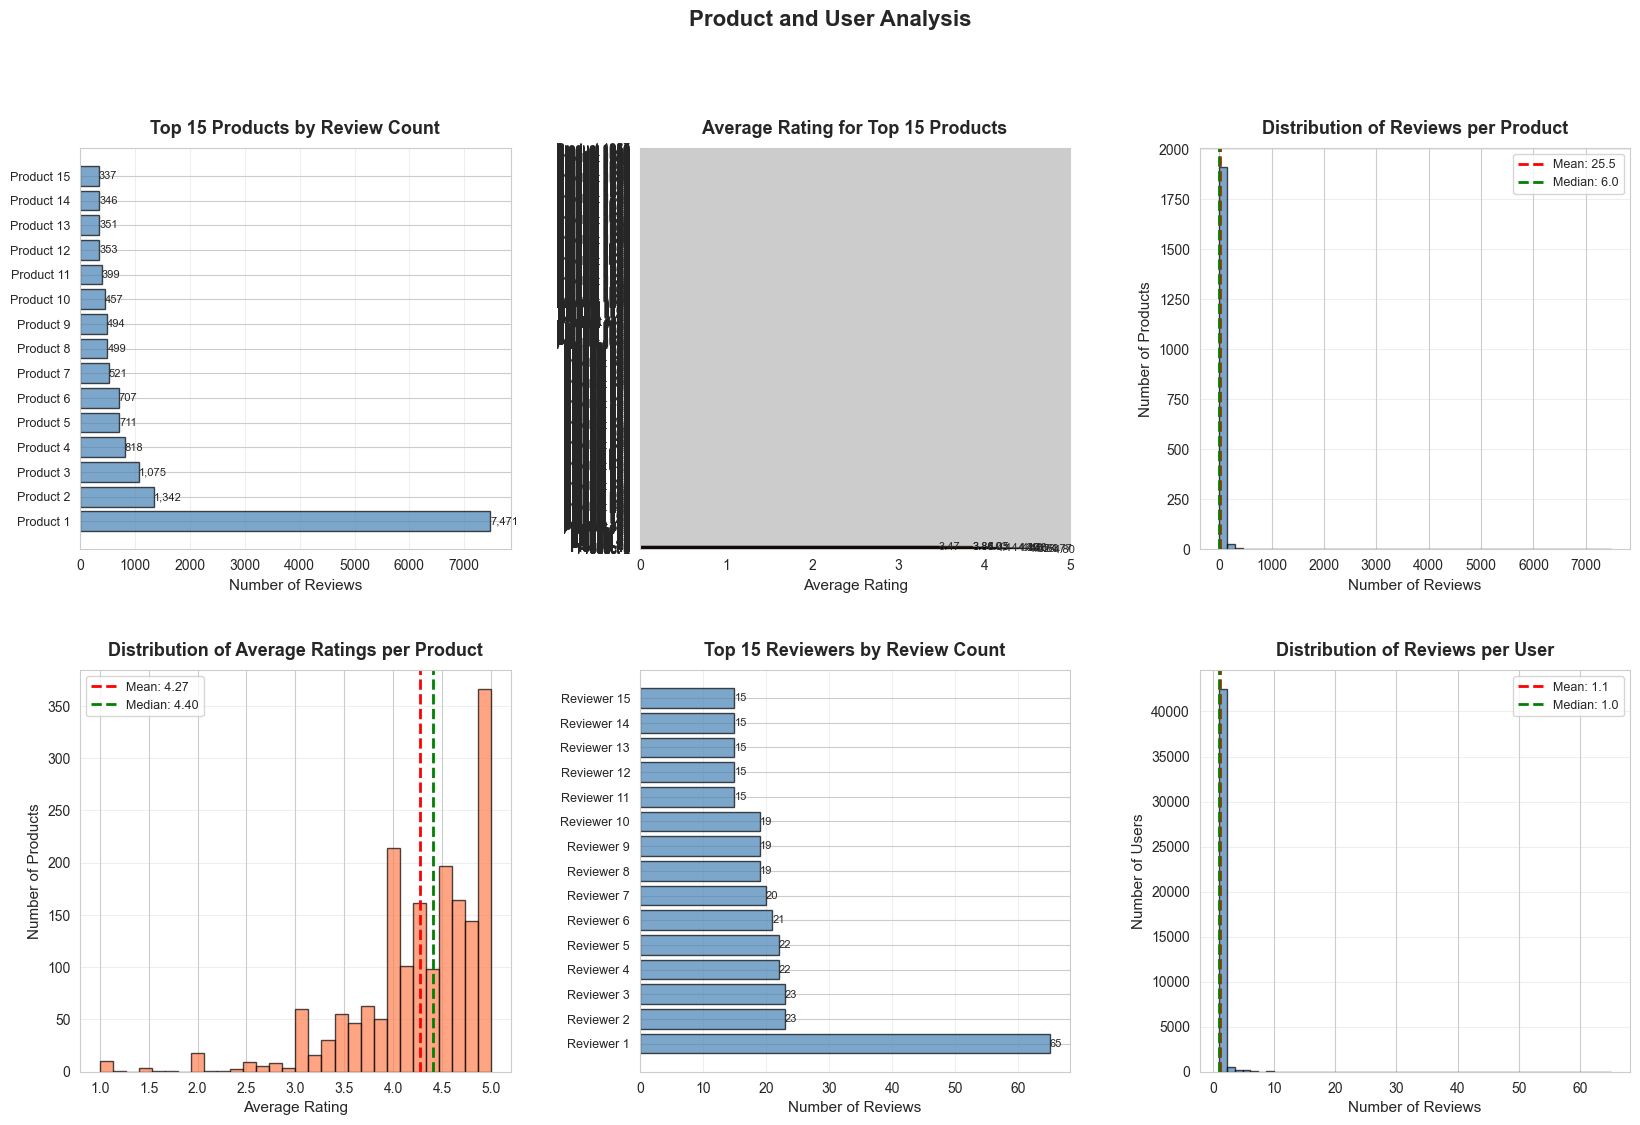


Product Statistics:
  Total unique products: 1,832
  Average reviews per product: 25.5
  Median reviews per product: 6.0
  Average rating across all products: 4.27
  Products with 1 review: 241 (12.3%)

User Statistics:
  Total unique users: 43,569
  Average reviews per user: 1.1
  Median reviews per user: 1.0
  Users with 1 review: 39,732 (91.2%)


In [14]:
# Product and user-level analysis
product_cols = [col for col in df_sample.columns if 'product' in col.lower() or 'asin' in col.lower()]
user_cols = [col for col in df_sample.columns if 'user' in col.lower() or 'reviewer' in col.lower()]

if (product_cols or user_cols) and 'overall' in df_sample.columns:
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    product_col = product_cols[0] if product_cols else None
    user_col = user_cols[0] if user_cols else None
    
    # 1. Top products by review count
    if product_col:
        ax1 = fig.add_subplot(gs[0, 0])
        top_products = df_sample[product_col].value_counts().head(15)
        bars = ax1.barh(range(len(top_products)), top_products.values, 
                       color='steelblue', alpha=0.7, edgecolor='black')
        ax1.set_yticks(range(len(top_products)))
        ax1.set_yticklabels([f"Product {i+1}" for i in range(len(top_products))], fontsize=9)
        ax1.set_xlabel('Number of Reviews', fontsize=11)
        ax1.set_title('Top 15 Products by Review Count', fontsize=13, fontweight='bold', pad=10)
        ax1.grid(axis='x', alpha=0.3)
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width, bar.get_y() + bar.get_height()/2.,
                    f'{int(width):,}', ha='left', va='center', fontsize=8)
    
    # 2. Average rating by product (top products)
    if product_col:
        ax2 = fig.add_subplot(gs[0, 1])
        top_product_ids = df_sample[product_col].value_counts().head(15).index
        avg_ratings = df_sample[df_sample[product_col].isin(top_product_ids)].groupby(product_col)['overall'].mean().sort_values(ascending=False)
        bars = ax2.barh(range(len(avg_ratings)), avg_ratings.values, 
                      color='coral', alpha=0.7, edgecolor='black')
        ax2.set_yticks(range(len(avg_ratings)))
        ax2.set_yticklabels([f"Product {i+1}" for i in range(len(avg_ratings))], fontsize=9)
        ax2.set_xlabel('Average Rating', fontsize=11)
        ax2.set_title('Average Rating for Top 15 Products', fontsize=13, fontweight='bold', pad=10)
        ax2.set_xlim([0, 5])
        ax2.grid(axis='x', alpha=0.3)
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax2.text(width, bar.get_y() + bar.get_height()/2.,
                    f'{width:.2f}', ha='left', va='center', fontsize=8)
    
    # 3. Review count distribution per product
    if product_col:
        ax3 = fig.add_subplot(gs[0, 2])
        review_counts_per_product = df_sample[product_col].value_counts()
        ax3.hist(review_counts_per_product.values, bins=50, color='steelblue', 
                edgecolor='black', alpha=0.7)
        ax3.axvline(review_counts_per_product.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {review_counts_per_product.mean():.1f}')
        ax3.axvline(review_counts_per_product.median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {review_counts_per_product.median():.1f}')
        ax3.set_title('Distribution of Reviews per Product', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xlabel('Number of Reviews', fontsize=11)
        ax3.set_ylabel('Number of Products', fontsize=11)
        ax3.legend(fontsize=9)
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. Average rating distribution across products
    if product_col:
        ax4 = fig.add_subplot(gs[1, 0])
        avg_ratings_all = df_sample.groupby(product_col)['overall'].mean()
        ax4.hist(avg_ratings_all.values, bins=30, color='coral', edgecolor='black', alpha=0.7)
        ax4.axvline(avg_ratings_all.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {avg_ratings_all.mean():.2f}')
        ax4.axvline(avg_ratings_all.median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {avg_ratings_all.median():.2f}')
        ax4.set_title('Distribution of Average Ratings per Product', fontsize=13, fontweight='bold', pad=10)
        ax4.set_xlabel('Average Rating', fontsize=11)
        ax4.set_ylabel('Number of Products', fontsize=11)
        ax4.legend(fontsize=9)
        ax4.grid(axis='y', alpha=0.3)
    
    # 5. Top reviewers
    if user_col:
        ax5 = fig.add_subplot(gs[1, 1])
        top_reviewers = df_sample[user_col].value_counts().head(15)
        bars = ax5.barh(range(len(top_reviewers)), top_reviewers.values, 
                      color='steelblue', alpha=0.7, edgecolor='black')
        ax5.set_yticks(range(len(top_reviewers)))
        ax5.set_yticklabels([f"Reviewer {i+1}" for i in range(len(top_reviewers))], fontsize=9)
        ax5.set_xlabel('Number of Reviews', fontsize=11)
        ax5.set_title('Top 15 Reviewers by Review Count', fontsize=13, fontweight='bold', pad=10)
        ax5.grid(axis='x', alpha=0.3)
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax5.text(width, bar.get_y() + bar.get_height()/2.,
                    f'{int(width):,}', ha='left', va='center', fontsize=8)
    
    # 6. Reviews per user distribution
    if user_col:
        ax6 = fig.add_subplot(gs[1, 2])
        reviews_per_user = df_sample[user_col].value_counts()
        ax6.hist(reviews_per_user.values, bins=50, color='steelblue', 
                edgecolor='black', alpha=0.7)
        ax6.axvline(reviews_per_user.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {reviews_per_user.mean():.1f}')
        ax6.axvline(reviews_per_user.median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {reviews_per_user.median():.1f}')
        ax6.set_title('Distribution of Reviews per User', fontsize=13, fontweight='bold', pad=10)
        ax6.set_xlabel('Number of Reviews', fontsize=11)
        ax6.set_ylabel('Number of Users', fontsize=11)
        ax6.legend(fontsize=9)
        ax6.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Product and User Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(FIGURES_DIR / 'product_user_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    if product_col:
        print(f"\nProduct Statistics:")
        print(f"  Total unique products: {df_sample[product_col].nunique():,}")
        print(f"  Average reviews per product: {review_counts_per_product.mean():.1f}")
        print(f"  Median reviews per product: {review_counts_per_product.median():.1f}")
        print(f"  Average rating across all products: {avg_ratings_all.mean():.2f}")
        print(f"  Products with 1 review: {(review_counts_per_product == 1).sum():,} ({(review_counts_per_product == 1).sum()/len(review_counts_per_product)*100:.1f}%)")
    
    if user_col:
        print(f"\nUser Statistics:")
        print(f"  Total unique users: {df_sample[user_col].nunique():,}")
        print(f"  Average reviews per user: {reviews_per_user.mean():.1f}")
        print(f"  Median reviews per user: {reviews_per_user.median():.1f}")
        print(f"  Users with 1 review: {(reviews_per_user == 1).sum():,} ({(reviews_per_user == 1).sum()/len(reviews_per_user)*100:.1f}%)")
else:
    print("Product or User ID columns not found. Skipping product/user-level analysis.")


## 5.7 Summary Dashboard - Key Insights


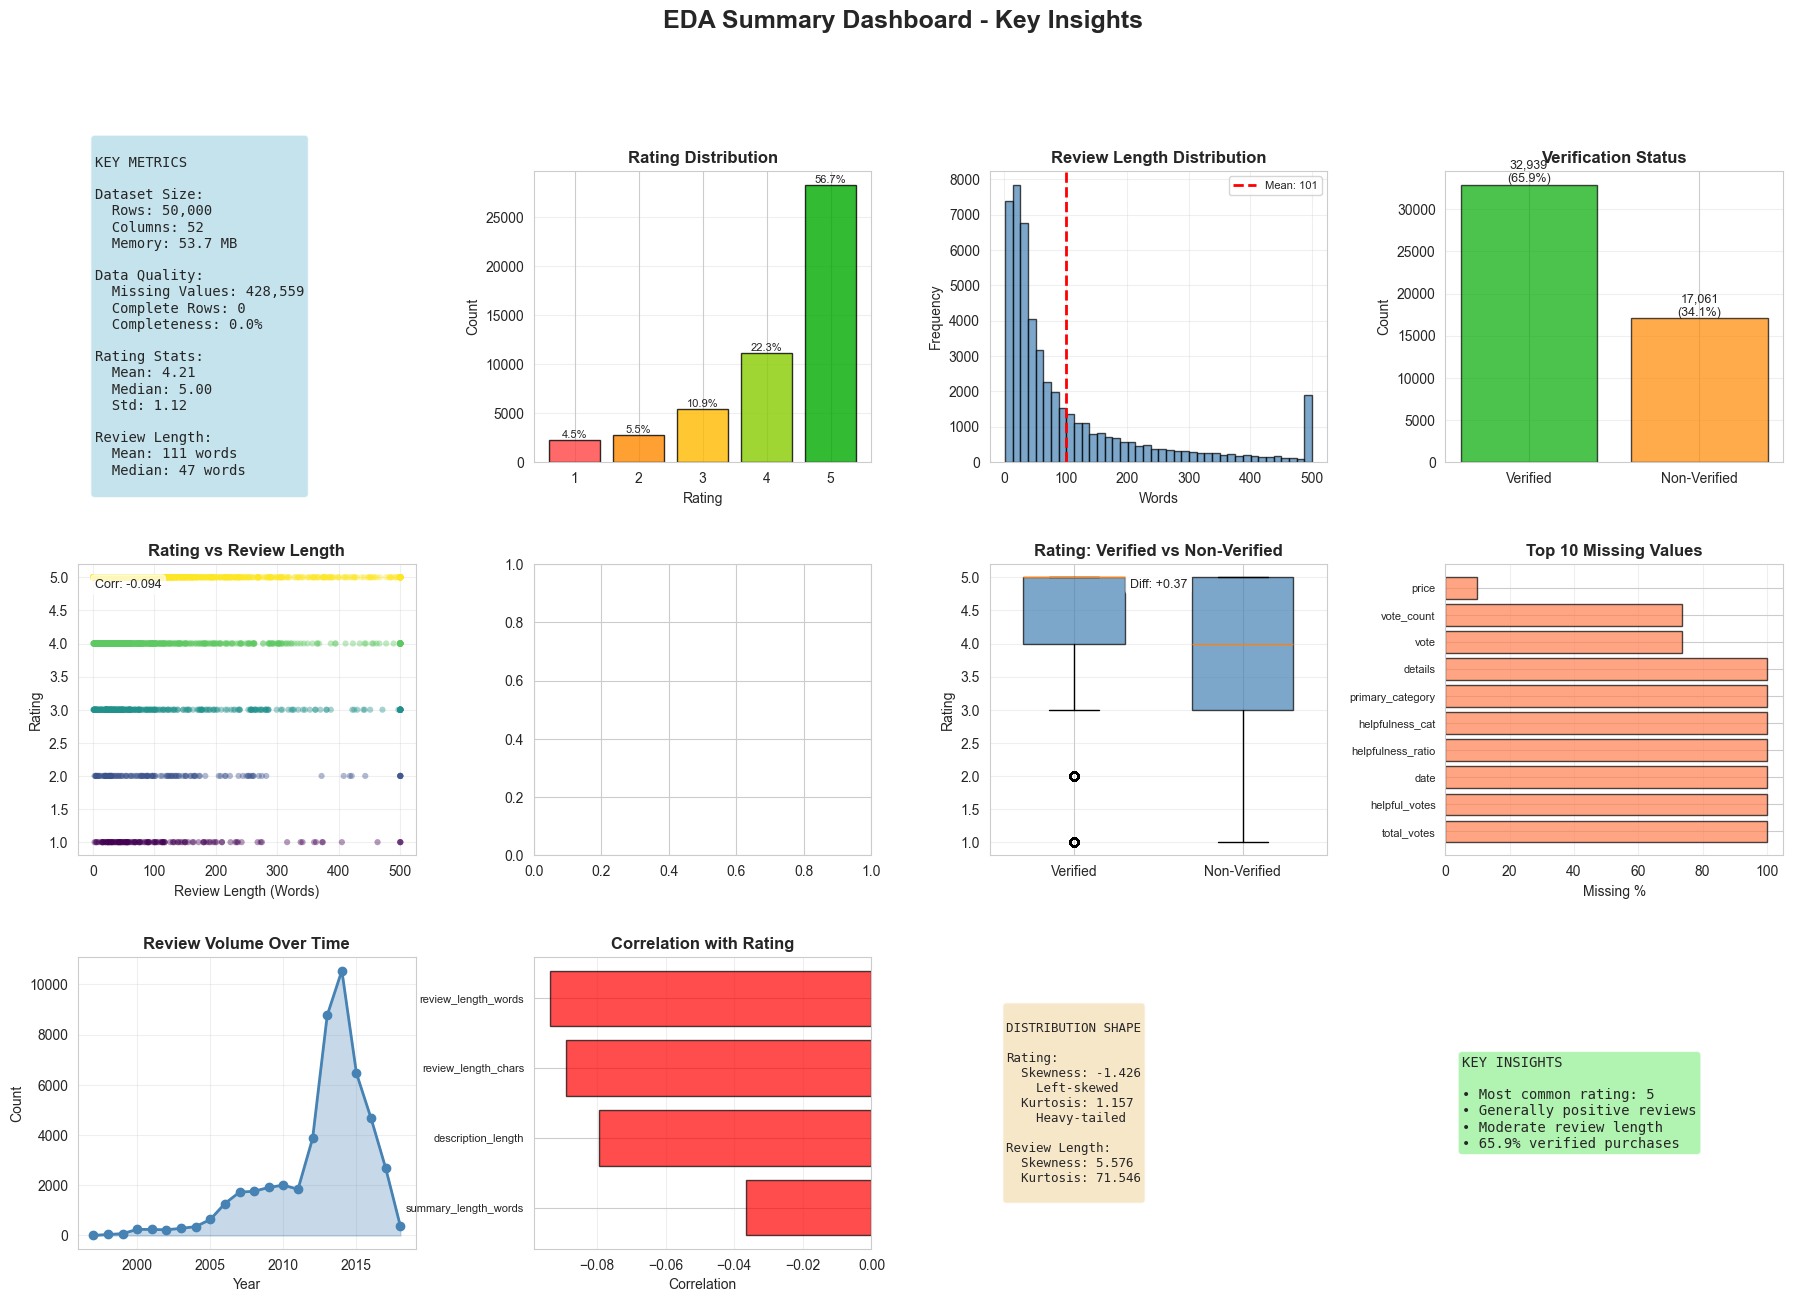


=== SUMMARY DASHBOARD CREATED ===
All figures saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\reports\figures


In [17]:
# Create a comprehensive summary dashboard
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# 1. Key metrics summary
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
metrics_text = f"""
KEY METRICS

Dataset Size:
  Rows: {len(df_sample):,}
  Columns: {len(df_sample.columns)}
  Memory: {df_sample.memory_usage(deep=True).sum() / 1024**2:.1f} MB

Data Quality:
  Missing Values: {df_sample.isnull().sum().sum():,}
  Complete Rows: {df_sample.dropna().shape[0]:,}
  Completeness: {df_sample.dropna().shape[0]/len(df_sample)*100:.1f}%
"""
if 'overall' in df_sample.columns:
    metrics_text += f"""
Rating Stats:
  Mean: {df_sample['overall'].mean():.2f}
  Median: {df_sample['overall'].median():.2f}
  Std: {df_sample['overall'].std():.2f}
"""
if 'review_length_words' in df_sample.columns:
    metrics_text += f"""
Review Length:
  Mean: {df_sample['review_length_words'].mean():.0f} words
  Median: {df_sample['review_length_words'].median():.0f} words
"""
ax1.text(0.05, 0.5, metrics_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# 2. Rating distribution (compact)
if 'overall' in df_sample.columns:
    ax2 = fig.add_subplot(gs[0, 1])
    rating_counts = df_sample['overall'].value_counts().sort_index()
    colors = ['#ff4444', '#ff8800', '#ffbb00', '#88cc00', '#00aa00']
    bars = ax2.bar(rating_counts.index, rating_counts.values,
                  color=colors[:len(rating_counts)], alpha=0.8, edgecolor='black')
    ax2.set_title('Rating Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Rating', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/len(df_sample)*100:.1f}%', ha='center', va='bottom', fontsize=8)

# 3. Review length distribution (compact)
if 'review_length_words' in df_sample.columns:
    ax3 = fig.add_subplot(gs[0, 2])
    review_lengths = df_sample['review_length_words'].clip(upper=500)
    ax3.hist(review_lengths, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.axvline(review_lengths.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {review_lengths.mean():.0f}')
    ax3.set_title('Review Length Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Words', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.legend(fontsize=8)
    ax3.grid(alpha=0.3)

# 4. Verification status
if 'is_verified' in df_sample.columns:
    ax4 = fig.add_subplot(gs[0, 3])
    verified_counts = df_sample['is_verified'].value_counts()
    colors_ver = ['#00aa00', '#ff8800']
    bars = ax4.bar(['Verified', 'Non-Verified'], verified_counts.values,
                  color=colors_ver, alpha=0.7, edgecolor='black')
    ax4.set_title('Verification Status', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=10)
    ax4.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/len(df_sample)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

# 5. Rating vs Review Length (compact)
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    ax5 = fig.add_subplot(gs[1, 0])
    plot_sample = df_sample.sample(n=min(3000, len(df_sample)), random_state=42)
    scatter = ax5.scatter(plot_sample['review_length_words'].clip(upper=500),
                         plot_sample['overall'], alpha=0.4, s=20,
                         c=plot_sample['overall'], cmap='viridis', edgecolors='none')
    ax5.set_title('Rating vs Review Length', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Review Length (Words)', fontsize=10)
    ax5.set_ylabel('Rating', fontsize=10)
    ax5.grid(alpha=0.3)
    corr = df_sample[['overall', 'review_length_words']].corr().iloc[0,1]
    ax5.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax5.transAxes,
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 6. Helpfulness analysis (if available)
if 'helpfulness_ratio' in df_sample.columns:
    ax6 = fig.add_subplot(gs[1, 1])
    helpful_data = df_sample['helpfulness_ratio'].dropna()
    if len(helpful_data) > 0:
        ax6.hist(helpful_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax6.axvline(helpful_data.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {helpful_data.mean():.3f}')
        ax6.set_title('Helpfulness Distribution', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Helpfulness Ratio', fontsize=10)
        ax6.set_ylabel('Frequency', fontsize=10)
        ax6.legend(fontsize=8)
        ax6.grid(alpha=0.3)

# 7. Verified vs Non-Verified comparison
if 'is_verified' in df_sample.columns and 'overall' in df_sample.columns:
    ax7 = fig.add_subplot(gs[1, 2])
    verified_ratings = df_sample[df_sample['is_verified'] == True]['overall']
    non_verified_ratings = df_sample[df_sample['is_verified'] == False]['overall']
    
    data_to_plot = [verified_ratings.values, non_verified_ratings.values]
    bp = ax7.boxplot(data_to_plot, labels=['Verified', 'Non-Verified'],
                    patch_artist=True, widths=0.6)
    for patch in bp['boxes']:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.7)
    ax7.set_title('Rating: Verified vs Non-Verified', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Rating', fontsize=10)
    ax7.grid(axis='y', alpha=0.3)
    diff = verified_ratings.mean() - non_verified_ratings.mean()
    ax7.text(0.5, 0.95, f'Diff: {diff:+.2f}', transform=ax7.transAxes,
            fontsize=9, ha='center', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 8. Missing values visualization
ax8 = fig.add_subplot(gs[1, 3])
missing = df_sample.isnull().sum()
missing_pct = (missing / len(df_sample)) * 100
missing_df = pd.DataFrame({'Column': missing.index, 'Missing %': missing_pct.values})
missing_df = missing_df[missing_df['Missing %'] > 0].sort_values('Missing %', ascending=False).head(10)

if len(missing_df) > 0:
    bars = ax8.barh(range(len(missing_df)), missing_df['Missing %'].values,
                   color='coral', alpha=0.7, edgecolor='black')
    ax8.set_yticks(range(len(missing_df)))
    ax8.set_yticklabels(missing_df['Column'].values, fontsize=8)
    ax8.set_title('Top 10 Missing Values', fontsize=12, fontweight='bold')
    ax8.set_xlabel('Missing %', fontsize=10)
    ax8.grid(axis='x', alpha=0.3)
else:
    ax8.text(0.5, 0.5, 'No missing values!', ha='center', va='center',
            transform=ax8.transAxes, fontsize=12, fontweight='bold')
    ax8.set_title('Missing Values', fontsize=12, fontweight='bold')

# 9. Temporal analysis (if available)
if 'review_datetime' in df_sample.columns:
    ax9 = fig.add_subplot(gs[2, 0])
    df_sample['review_datetime'] = pd.to_datetime(df_sample['review_datetime'], errors='coerce')
    df_sample['review_year'] = df_sample['review_datetime'].dt.year
    yearly_counts = df_sample.groupby('review_year').size()
    ax9.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2,
            markersize=6, color='steelblue')
    ax9.fill_between(yearly_counts.index, yearly_counts.values, alpha=0.3, color='steelblue')
    ax9.set_title('Review Volume Over Time', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Year', fontsize=10)
    ax9.set_ylabel('Count', fontsize=10)
    ax9.grid(alpha=0.3)

# 10. Correlation summary
if 'overall' in df_sample.columns:
    ax10 = fig.add_subplot(gs[2, 1])
    numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
    key_cols = [col for col in numeric_cols if any(x in col.lower() for x in 
                ['overall', 'length', 'helpful'])]
    if len(key_cols) > 1:
        corr_with_rating = df_sample[key_cols].corr()['overall'].drop('overall').sort_values(ascending=False)
        if len(corr_with_rating) > 0:
            bars = ax10.barh(range(len(corr_with_rating)), corr_with_rating.values,
                           color=['red' if x < 0 else 'blue' for x in corr_with_rating.values],
                           alpha=0.7, edgecolor='black')
            ax10.set_yticks(range(len(corr_with_rating)))
            ax10.set_yticklabels(corr_with_rating.index, fontsize=8)
            ax10.set_title('Correlation with Rating', fontsize=12, fontweight='bold')
            ax10.set_xlabel('Correlation', fontsize=10)
            ax10.axvline(0, color='black', linestyle='-', linewidth=0.5)
            ax10.grid(axis='x', alpha=0.3)

# 11. Distribution shape metrics
if 'overall' in df_sample.columns:
    ax11 = fig.add_subplot(gs[2, 2])
    ax11.axis('off')
    from scipy.stats import skew, kurtosis
    skewness = skew(df_sample['overall'])
    kurt = kurtosis(df_sample['overall'])
    shape_text = f"""
DISTRIBUTION SHAPE

Rating:
  Skewness: {skewness:.3f}
    {'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetric'}
  Kurtosis: {kurt:.3f}
    {'Heavy-tailed' if kurt > 0 else 'Light-tailed' if kurt < 0 else 'Normal-tailed'}
"""
    if 'review_length_words' in df_sample.columns:
        len_skew = skew(df_sample['review_length_words'])
        len_kurt = kurtosis(df_sample['review_length_words'])
        shape_text += f"""
Review Length:
  Skewness: {len_skew:.3f}
  Kurtosis: {len_kurt:.3f}
"""
    ax11.text(0.05, 0.5, shape_text, fontsize=9, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# 12. Key insights summary
ax12 = fig.add_subplot(gs[2, 3])
ax12.axis('off')
insights = []
if 'overall' in df_sample.columns:
    mode_rating = df_sample['overall'].mode()[0]
    insights.append(f"• Most common rating: {mode_rating}")
    if df_sample['overall'].mean() > 3.5:
        insights.append("• Generally positive reviews")
    elif df_sample['overall'].mean() < 2.5:
        insights.append("• Generally negative reviews")
    else:
        insights.append("• Mixed review sentiment")

if 'review_length_words' in df_sample.columns:
    avg_len = df_sample['review_length_words'].mean()
    if avg_len > 200:
        insights.append("• Reviews are generally long")
    elif avg_len < 100:
        insights.append("• Reviews are generally short")
    else:
        insights.append("• Moderate review length")

if 'is_verified' in df_sample.columns:
    verified_pct = df_sample['is_verified'].sum() / len(df_sample) * 100
    insights.append(f"• {verified_pct:.1f}% verified purchases")

insights_text = "KEY INSIGHTS\n\n" + "\n".join(insights[:8])  # Limit to 8 insights
ax12.text(0.05, 0.5, insights_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.suptitle('EDA Summary Dashboard - Key Insights', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(FIGURES_DIR / 'summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== SUMMARY DASHBOARD CREATED ===")
print(f"All figures saved to: {FIGURES_DIR}")


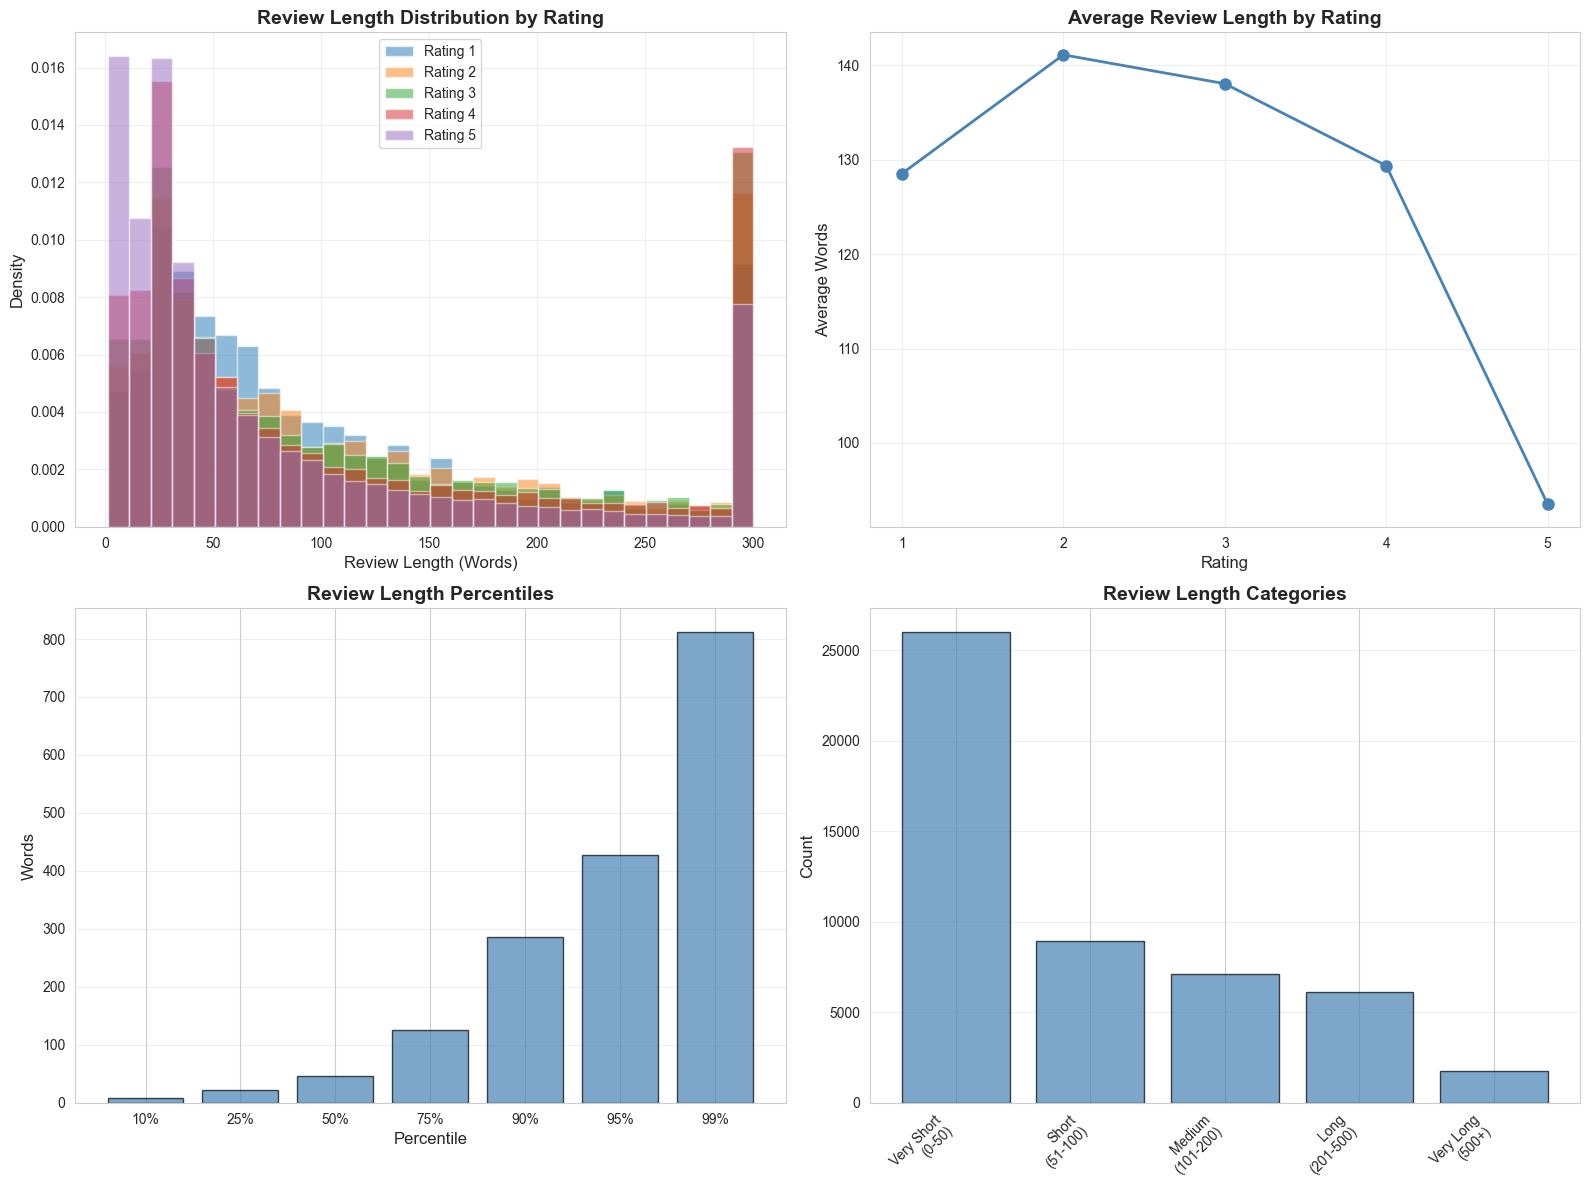


Review Length by Category:
  Very Short
(0-50): 26,016 (52.0%)
  Short
(51-100): 8,953 (17.9%)
  Medium
(101-200): 7,143 (14.3%)
  Long
(201-500): 6,124 (12.2%)
  Very Long
(500+): 1,764 (3.5%)


In [18]:
# Review text analysis (if available)
text_cols = [col for col in df_sample.columns if 'review' in col.lower() and 'text' in col.lower()]

if text_cols and 'review_length_words' in df_sample.columns:
    text_col = text_cols[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Word count distribution by rating
    for rating in sorted(df_sample['overall'].unique()):
        rating_data = df_sample[df_sample['overall'] == rating]['review_length_words']
        axes[0, 0].hist(rating_data.clip(upper=300), bins=30, alpha=0.5, 
                       label=f'Rating {int(rating)}', density=True)
    axes[0, 0].set_title('Review Length Distribution by Rating', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Review Length (Words)', fontsize=12)
    axes[0, 0].set_ylabel('Density', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Average review length by rating
    avg_length_by_rating = df_sample.groupby('overall')['review_length_words'].mean()
    axes[0, 1].plot(avg_length_by_rating.index, avg_length_by_rating.values, 
                    marker='o', linewidth=2, markersize=8, color='steelblue')
    axes[0, 1].set_title('Average Review Length by Rating', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Rating', fontsize=12)
    axes[0, 1].set_ylabel('Average Words', fontsize=12)
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xticks(avg_length_by_rating.index)
    
    # Review length percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    length_percentiles = [df_sample['review_length_words'].quantile(p/100) for p in percentiles]
    axes[1, 0].bar(range(len(percentiles)), length_percentiles, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xticks(range(len(percentiles)))
    axes[1, 0].set_xticklabels([f'{p}%' for p in percentiles])
    axes[1, 0].set_title('Review Length Percentiles', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Percentile', fontsize=12)
    axes[1, 0].set_ylabel('Words', fontsize=12)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Review length categories
    df_sample['length_category'] = pd.cut(df_sample['review_length_words'], 
                                          bins=[0, 50, 100, 200, 500, float('inf')],
                                          labels=['Very Short\n(0-50)', 'Short\n(51-100)', 
                                                 'Medium\n(101-200)', 'Long\n(201-500)', 
                                                 'Very Long\n(500+)'])
    length_cat_counts = df_sample['length_category'].value_counts().sort_index()
    axes[1, 1].bar(range(len(length_cat_counts)), length_cat_counts.values, 
                  color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xticks(range(len(length_cat_counts)))
    axes[1, 1].set_xticklabels(length_cat_counts.index, rotation=45, ha='right')
    axes[1, 1].set_title('Review Length Categories', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Count', fontsize=12)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'review_text_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nReview Length by Category:")
    for cat, count in length_cat_counts.items():
        print(f"  {cat}: {count:,} ({count/len(df_sample)*100:.1f}%)")


## 6. Statistical Tests


=== CORRELATION ANALYSIS ===


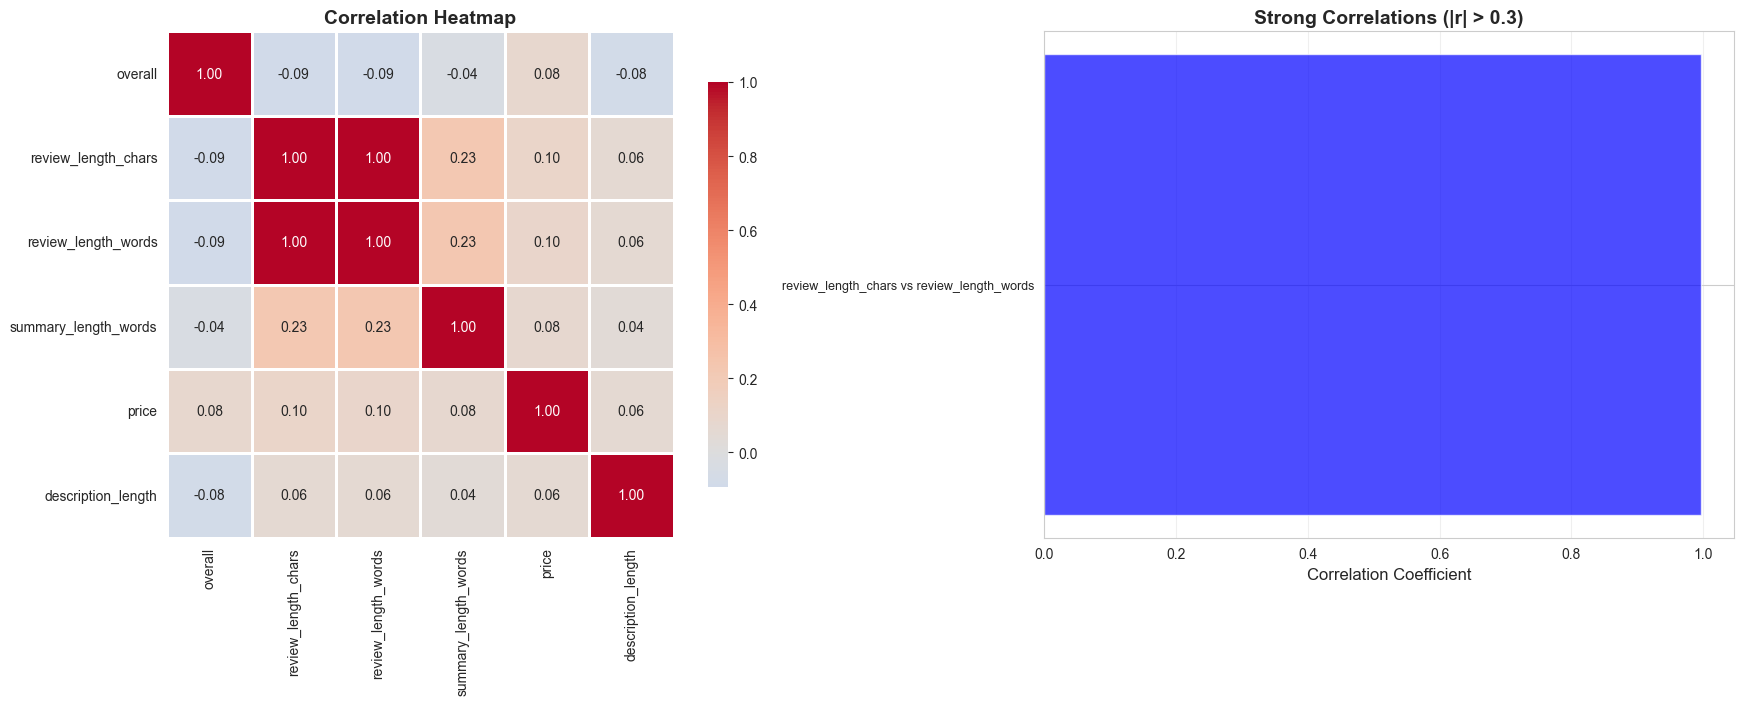


Top Correlations:
review_length_chars   review_length_words     0.997344
summary_length_words  review_length_words     0.230025
review_length_chars   summary_length_words    0.226264
                      price                   0.104193
price                 review_length_words     0.101667
                      overall                 0.082001
                      summary_length_words    0.080393
                      description_length      0.061002
description_length    review_length_words     0.060937
                      review_length_chars     0.058123
dtype: float64

Bottom Correlations (most negative):
description_length   summary_length_words    0.035104
overall              summary_length_words   -0.036628
                     description_length     -0.079527
review_length_chars  overall                -0.089117
overall              review_length_words    -0.093718
dtype: float64


In [19]:
from scipy import stats

# Correlation analysis - Enhanced
print("=== CORRELATION ANALYSIS ===")
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
# Filter to key columns
key_cols = [col for col in numeric_cols if any(x in col.lower() for x in 
            ['overall', 'length', 'helpful', 'price', 'rating'])]

if len(key_cols) > 1:
    corr_matrix = df_sample[key_cols].corr()
    
    # Enhanced correlation heatmap
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Standard heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
    axes[0].set_title('Correlation Heatmap', fontsize=14, fontweight='bold')
    
    # Clustered heatmap (separate figure)
    try:
        g = sns.clustermap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                           square=True, linewidths=1, figsize=(10, 8), cbar_kws={"shrink": 0.8})
        plt.savefig(FIGURES_DIR / 'correlation_heatmap_clustered.png', dpi=300, bbox_inches='tight')
        plt.close()
    except:
        pass
    
    # Correlation network (simplified)
    # Get strong correlations
    strong_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.3:  # Threshold for strong correlation
                strong_corr.append({
                    'var1': corr_matrix.columns[i],
                    'var2': corr_matrix.columns[j],
                    'corr': corr_val
                })
    
    if strong_corr:
        corr_df = pd.DataFrame(strong_corr).sort_values('corr', key=abs, ascending=False)
        axes[1].barh(range(len(corr_df)), corr_df['corr'].values, 
                    color=['red' if x < 0 else 'blue' for x in corr_df['corr'].values], alpha=0.7)
        axes[1].set_yticks(range(len(corr_df)))
        axes[1].set_yticklabels([f"{row['var1']} vs {row['var2']}" 
                                for _, row in corr_df.iterrows()], fontsize=9)
        axes[1].set_xlabel('Correlation Coefficient', fontsize=12)
        axes[1].set_title('Strong Correlations (|r| > 0.3)', fontsize=14, fontweight='bold')
        axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No strong correlations found', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
        axes[1].set_title('Strong Correlations', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop Correlations:")
    # Get upper triangle of correlation matrix
    corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
    # Remove self-correlations and duplicates
    corr_pairs = corr_pairs[corr_pairs < 1.0].drop_duplicates()
    print(corr_pairs.head(10))
    
    print("\nBottom Correlations (most negative):")
    print(corr_pairs.tail(5))


In [20]:
# Additional statistical tests and analysis
print("\n=== ADDITIONAL STATISTICAL ANALYSIS ===")

# Normality tests for rating distribution
if 'overall' in df_sample.columns:
    from scipy.stats import shapiro, normaltest
    
    # Shapiro-Wilk test (for smaller samples)
    if len(df_sample) <= 5000:
        stat_sw, p_sw = shapiro(df_sample['overall'].sample(n=min(5000, len(df_sample)), random_state=42))
        print(f"\nShapiro-Wilk Normality Test:")
        print(f"  Statistic: {stat_sw:.4f}")
        print(f"  p-value: {p_sw:.2e}")
        print(f"  Normal distribution: {'Yes' if p_sw > 0.05 else 'No'}")
    
    # D'Agostino's normality test
    stat_da, p_da = normaltest(df_sample['overall'])
    print(f"\nD'Agostino's Normality Test:")
    print(f"  Statistic: {stat_da:.2f}")
    print(f"  p-value: {p_da:.2e}")
    print(f"  Normal distribution: {'Yes' if p_da > 0.05 else 'No'}")

# Skewness and Kurtosis
if 'overall' in df_sample.columns:
    from scipy.stats import skew, kurtosis
    skewness = skew(df_sample['overall'])
    kurt = kurtosis(df_sample['overall'])
    print(f"\nDistribution Shape:")
    print(f"  Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetric'})")
    print(f"  Kurtosis: {kurt:.3f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed' if kurt < 0 else 'Normal-tailed'})")

# Review length statistics
if 'review_length_words' in df_sample.columns:
    print(f"\nReview Length Statistics:")
    print(f"  Skewness: {skew(df_sample['review_length_words']):.3f}")
    print(f"  Kurtosis: {kurtosis(df_sample['review_length_words']):.3f}")



=== ADDITIONAL STATISTICAL ANALYSIS ===

D'Agostino's Normality Test:
  Statistic: 10923.33
  p-value: 0.00e+00
  Normal distribution: No

Distribution Shape:
  Skewness: -1.426 (Left-skewed)
  Kurtosis: 1.157 (Heavy-tailed)

Review Length Statistics:
  Skewness: 5.576
  Kurtosis: 71.546


In [21]:
# Compare verified vs non-verified ratings - Enhanced statistical tests
if 'is_verified' in df_sample.columns and 'overall' in df_sample.columns:
    print("\n=== VERIFIED VS NON-VERIFIED RATINGS ===")
    
    verified_ratings = df_sample[df_sample['is_verified'] == True]['overall']
    non_verified_ratings = df_sample[df_sample['is_verified'] == False]['overall']
    
    print(f"Verified - Mean: {verified_ratings.mean():.2f}, Std: {verified_ratings.std():.2f}, N: {len(verified_ratings):,}")
    print(f"Non-verified - Mean: {non_verified_ratings.mean():.2f}, Std: {non_verified_ratings.std():.2f}, N: {len(non_verified_ratings):,}")
    
    # Multiple statistical tests
    print(f"\n=== STATISTICAL TESTS ===")
    
    # Mann-Whitney U Test (non-parametric)
    statistic_mw, p_value_mw = stats.mannwhitneyu(verified_ratings, non_verified_ratings, alternative='two-sided')
    print(f"Mann-Whitney U Test:")
    print(f"  Statistic: {statistic_mw:.2f}")
    print(f"  p-value: {p_value_mw:.2e}")
    print(f"  Significant difference: {'Yes' if p_value_mw < 0.05 else 'No'}")
    
    # T-test (parametric)
    statistic_t, p_value_t = stats.ttest_ind(verified_ratings, non_verified_ratings)
    print(f"\nIndependent T-Test:")
    print(f"  Statistic: {statistic_t:.2f}")
    print(f"  p-value: {p_value_t:.2e}")
    print(f"  Significant difference: {'Yes' if p_value_t < 0.05 else 'No'}")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(verified_ratings) - 1) * verified_ratings.std()**2 + 
                         (len(non_verified_ratings) - 1) * non_verified_ratings.std()**2) / 
                        (len(verified_ratings) + len(non_verified_ratings) - 2))
    cohens_d = (verified_ratings.mean() - non_verified_ratings.mean()) / pooled_std
    print(f"\nEffect Size (Cohen's d): {cohens_d:.3f}")
    if abs(cohens_d) < 0.2:
        effect_size = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "small"
    elif abs(cohens_d) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    print(f"  Effect size interpretation: {effect_size}")
    
    # Confidence intervals
    from scipy.stats import sem, t
    def confidence_interval(data, confidence=0.95):
        n = len(data)
        mean = np.mean(data)
        std_err = sem(data)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        return mean - h, mean + h
    
    ci_verified = confidence_interval(verified_ratings)
    ci_non_verified = confidence_interval(non_verified_ratings)
    print(f"\n95% Confidence Intervals:")
    print(f"  Verified: [{ci_verified[0]:.2f}, {ci_verified[1]:.2f}]")
    print(f"  Non-Verified: [{ci_non_verified[0]:.2f}, {ci_non_verified[1]:.2f}]")



=== VERIFIED VS NON-VERIFIED RATINGS ===
Verified - Mean: 4.34, Std: 1.04, N: 32,939
Non-verified - Mean: 3.97, Std: 1.23, N: 17,061

=== STATISTICAL TESTS ===
Mann-Whitney U Test:
  Statistic: 331274000.50
  p-value: 1.05e-293
  Significant difference: Yes

Independent T-Test:
  Statistic: 35.79
  p-value: 5.69e-277
  Significant difference: Yes

Effect Size (Cohen's d): 0.338
  Effect size interpretation: small

95% Confidence Intervals:
  Verified: [4.33, 4.35]
  Non-Verified: [3.95, 3.98]


## 7. Temporal Analysis


=== TEMPORAL ANALYSIS ===


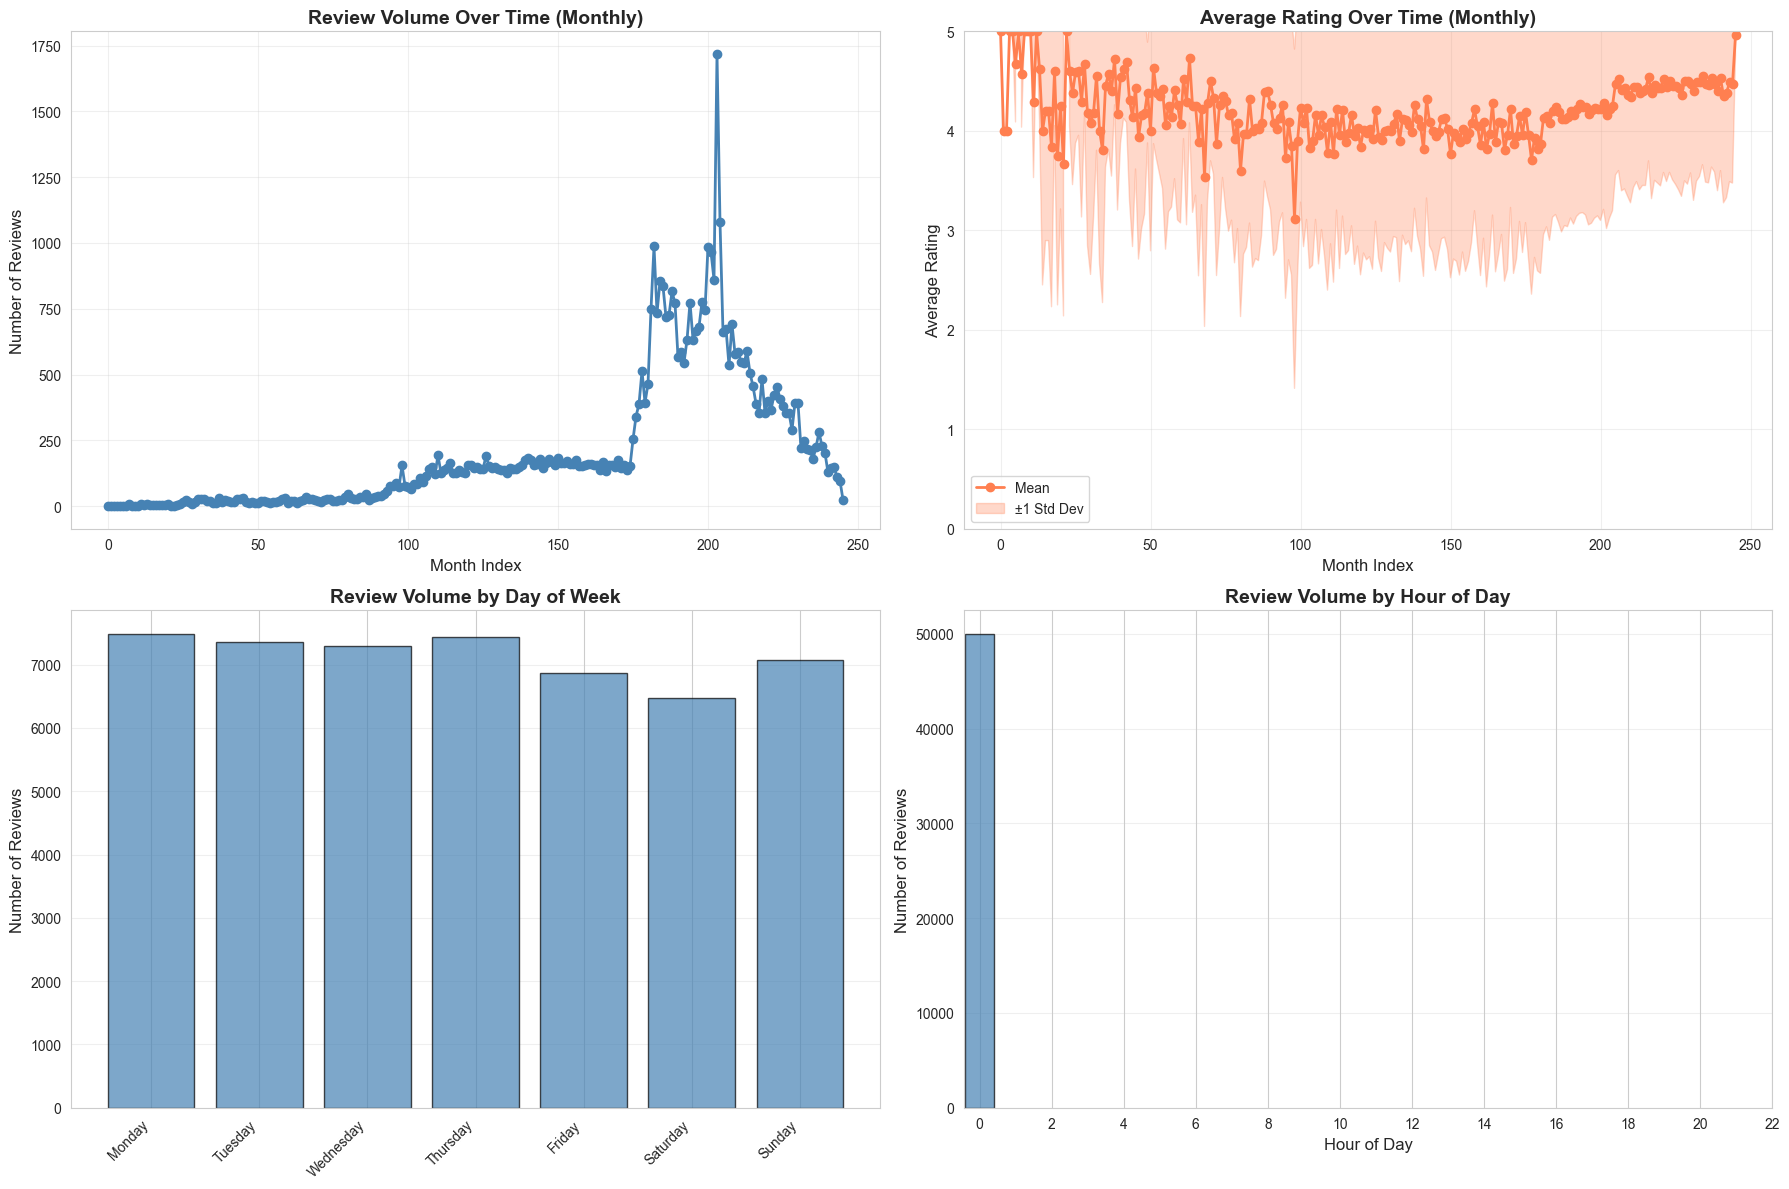

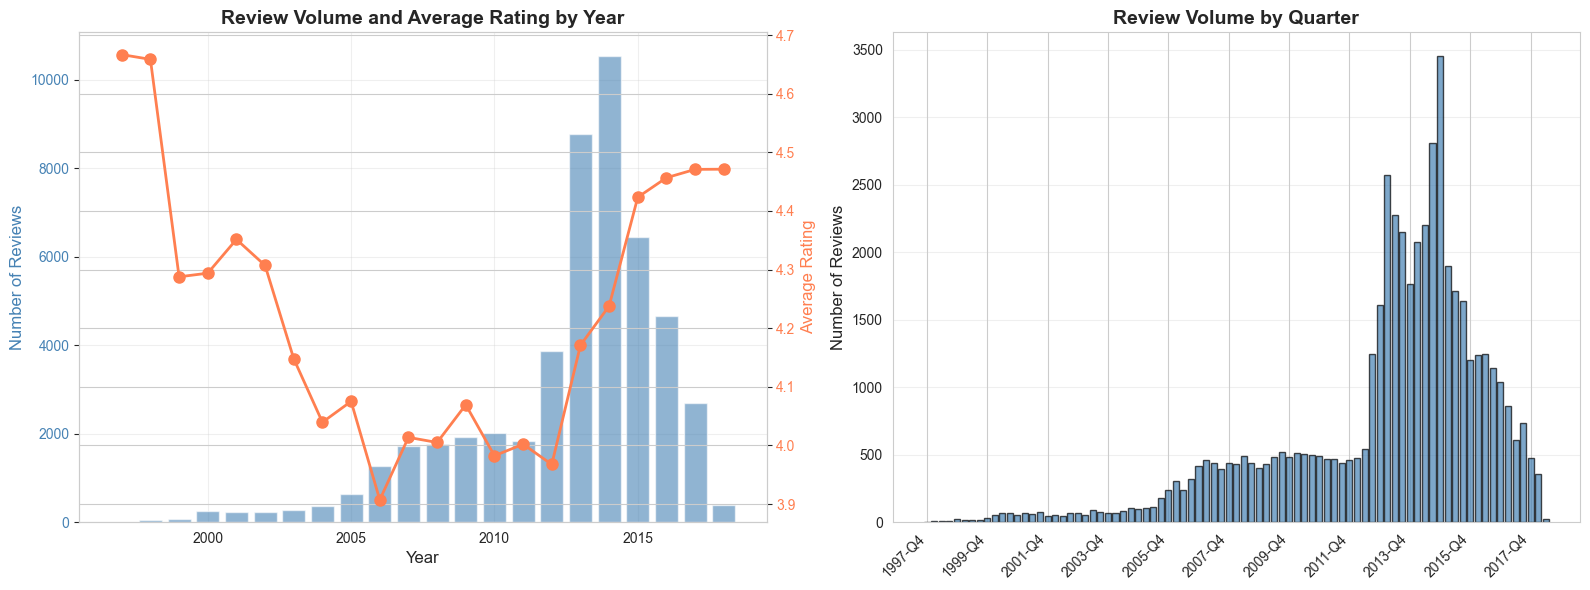


Temporal Statistics:
  Date range: 1997-10-16 00:00:00+00:00 to 2018-04-13 00:00:00+00:00
  Total months: 246
  Average reviews per month: 203
  Peak month: 2014-10 with 1,718 reviews


In [22]:
# Review volume over time - Enhanced temporal analysis
if 'review_datetime' in df_sample.columns:
    print("=== TEMPORAL ANALYSIS ===")
    
    # Convert to datetime if not already
    df_sample['review_datetime'] = pd.to_datetime(df_sample['review_datetime'])
    
    # Create time-based features
    df_sample['review_month'] = df_sample['review_datetime'].dt.to_period('M')
    df_sample['review_year'] = df_sample['review_datetime'].dt.year
    df_sample['review_quarter'] = df_sample['review_datetime'].dt.quarter
    df_sample['review_day_of_week'] = df_sample['review_datetime'].dt.day_name()
    df_sample['review_hour'] = df_sample['review_datetime'].dt.hour
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Monthly review counts
    monthly_counts = df_sample.groupby('review_month').size()
    axes[0, 0].plot(range(len(monthly_counts)), monthly_counts.values, 
                   marker='o', linewidth=2, markersize=6, color='steelblue')
    axes[0, 0].set_title('Review Volume Over Time (Monthly)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month Index', fontsize=12)
    axes[0, 0].set_ylabel('Number of Reviews', fontsize=12)
    axes[0, 0].grid(alpha=0.3)
    
    # Average rating over time
    if 'overall' in df_sample.columns:
        monthly_avg_rating = df_sample.groupby('review_month')['overall'].mean()
        monthly_std_rating = df_sample.groupby('review_month')['overall'].std()
        
        axes[0, 1].plot(range(len(monthly_avg_rating)), monthly_avg_rating.values, 
                       marker='o', linewidth=2, markersize=6, color='coral', label='Mean')
        axes[0, 1].fill_between(range(len(monthly_avg_rating)), 
                                monthly_avg_rating.values - monthly_std_rating.values,
                                monthly_avg_rating.values + monthly_std_rating.values,
                                alpha=0.3, color='coral', label='±1 Std Dev')
        axes[0, 1].set_title('Average Rating Over Time (Monthly)', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Month Index', fontsize=12)
        axes[0, 1].set_ylabel('Average Rating', fontsize=12)
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        axes[0, 1].set_ylim([0, 5])
    
    # Reviews by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = df_sample['review_day_of_week'].value_counts().reindex(day_order, fill_value=0)
    axes[1, 0].bar(range(len(day_counts)), day_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xticks(range(len(day_counts)))
    axes[1, 0].set_xticklabels(day_counts.index, rotation=45, ha='right')
    axes[1, 0].set_title('Review Volume by Day of Week', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Reviews', fontsize=12)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Reviews by hour of day
    hour_counts = df_sample['review_hour'].value_counts().sort_index()
    axes[1, 1].bar(hour_counts.index, hour_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Review Volume by Hour of Day', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Hour of Day', fontsize=12)
    axes[1, 1].set_ylabel('Number of Reviews', fontsize=12)
    axes[1, 1].set_xticks(range(0, 24, 2))
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Yearly and quarterly analysis
    if 'overall' in df_sample.columns:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Yearly analysis
        yearly_counts = df_sample.groupby('review_year').size()
        yearly_avg_rating = df_sample.groupby('review_year')['overall'].mean()
        
        ax1 = axes[0]
        ax1_twin = ax1.twinx()
        bars = ax1.bar(yearly_counts.index, yearly_counts.values, alpha=0.6, color='steelblue', label='Count')
        line = ax1_twin.plot(yearly_avg_rating.index, yearly_avg_rating.values, 
                            marker='o', color='coral', linewidth=2, markersize=8, label='Avg Rating')
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Number of Reviews', fontsize=12, color='steelblue')
        ax1_twin.set_ylabel('Average Rating', fontsize=12, color='coral')
        ax1.set_title('Review Volume and Average Rating by Year', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='steelblue')
        ax1_twin.tick_params(axis='y', labelcolor='coral')
        ax1.grid(alpha=0.3)
        
        # Quarterly analysis
        quarterly_counts = df_sample.groupby(['review_year', 'review_quarter']).size()
        quarterly_avg_rating = df_sample.groupby(['review_year', 'review_quarter'])['overall'].mean()
        
        quarters = [f"{y}-Q{q}" for y, q in quarterly_counts.index]
        axes[1].bar(range(len(quarters)), quarterly_counts.values, alpha=0.7, color='steelblue', edgecolor='black')
        axes[1].set_xticks(range(0, len(quarters), max(1, len(quarters)//10)))
        axes[1].set_xticklabels([quarters[i] for i in range(0, len(quarters), max(1, len(quarters)//10))], 
                               rotation=45, ha='right')
        axes[1].set_title('Review Volume by Quarter', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Number of Reviews', fontsize=12)
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'yearly_quarterly_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nTemporal Statistics:")
        print(f"  Date range: {df_sample['review_datetime'].min()} to {df_sample['review_datetime'].max()}")
        print(f"  Total months: {df_sample['review_month'].nunique()}")
        print(f"  Average reviews per month: {monthly_counts.mean():.0f}")
        print(f"  Peak month: {monthly_counts.idxmax()} with {monthly_counts.max():,} reviews")


## 8. Advanced Visualizations - Word Cloud and Sentiment Indicators


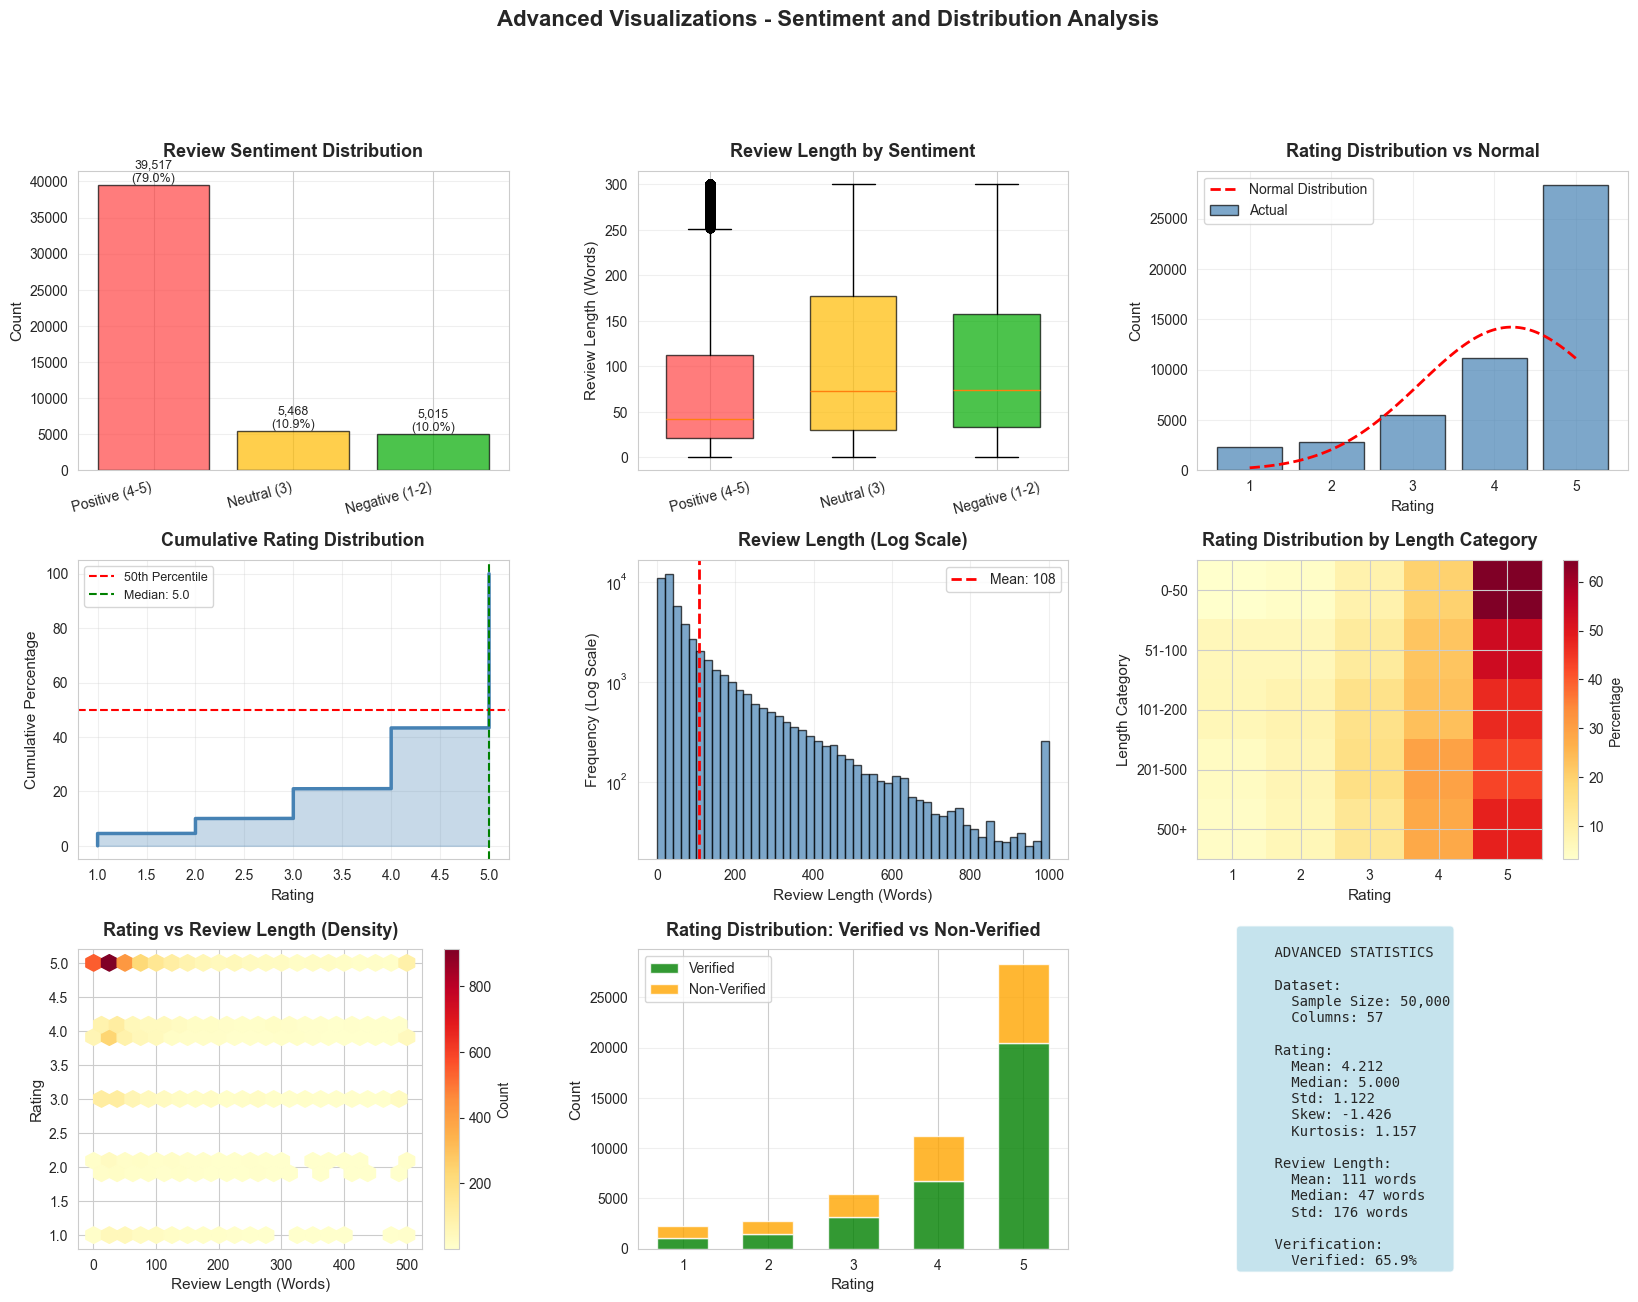


✅ Advanced visualizations created successfully!


In [23]:
# Advanced visualizations: Word frequency and sentiment indicators
try:
    from wordcloud import WordCloud
    wordcloud_available = True
except ImportError:
    wordcloud_available = False
    print("WordCloud not available. Install with: pip install wordcloud")

# Create comprehensive sentiment and text analysis visualizations
if 'review_length_words' in df_sample.columns and 'overall' in df_sample.columns:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Rating sentiment distribution (positive/negative/neutral)
    ax1 = fig.add_subplot(gs[0, 0])
    df_sample['sentiment_category'] = pd.cut(df_sample['overall'], 
                                              bins=[0, 2, 3, 5],
                                              labels=['Negative (1-2)', 'Neutral (3)', 'Positive (4-5)'])
    sentiment_counts = df_sample['sentiment_category'].value_counts()
    colors_sent = ['#ff4444', '#ffbb00', '#00aa00']
    bars = ax1.bar(range(len(sentiment_counts)), sentiment_counts.values,
                  color=colors_sent, alpha=0.7, edgecolor='black')
    ax1.set_xticks(range(len(sentiment_counts)))
    ax1.set_xticklabels(sentiment_counts.index, rotation=15, ha='right')
    ax1.set_title('Review Sentiment Distribution', fontsize=13, fontweight='bold', pad=10)
    ax1.set_ylabel('Count', fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/len(df_sample)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)
    
    # 2. Review length by sentiment category
    ax2 = fig.add_subplot(gs[0, 1])
    sentiment_groups = [df_sample[df_sample['sentiment_category'] == cat]['review_length_words'].clip(upper=300).values 
                       for cat in sentiment_counts.index]
    bp = ax2.boxplot(sentiment_groups, labels=sentiment_counts.index, patch_artist=True, widths=0.6)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(colors_sent[i])
        patch.set_alpha(0.7)
    ax2.set_title('Review Length by Sentiment', fontsize=13, fontweight='bold', pad=10)
    ax2.set_ylabel('Review Length (Words)', fontsize=11)
    ax2.tick_params(axis='x', rotation=15)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Rating distribution with normal curve overlay
    ax3 = fig.add_subplot(gs[0, 2])
    if 'overall' in df_sample.columns:
        rating_counts = df_sample['overall'].value_counts().sort_index()
        ax3.bar(rating_counts.index, rating_counts.values, alpha=0.7, 
               color='steelblue', edgecolor='black', label='Actual')
        # Overlay normal distribution
        from scipy.stats import norm
        mu, sigma = df_sample['overall'].mean(), df_sample['overall'].std()
        x = np.linspace(df_sample['overall'].min(), df_sample['overall'].max(), 100)
        y = norm.pdf(x, mu, sigma) * len(df_sample) * (df_sample['overall'].max() - df_sample['overall'].min()) / 5
        ax3.plot(x, y, 'r--', linewidth=2, label='Normal Distribution')
        ax3.set_title('Rating Distribution vs Normal', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xlabel('Rating', fontsize=11)
        ax3.set_ylabel('Count', fontsize=11)
        ax3.legend()
        ax3.grid(alpha=0.3)
    
    # 4. Cumulative rating percentage
    ax4 = fig.add_subplot(gs[1, 0])
    rating_sorted = np.sort(df_sample['overall'])
    cumulative_pct = np.arange(1, len(rating_sorted) + 1) / len(rating_sorted) * 100
    ax4.plot(rating_sorted, cumulative_pct, linewidth=2.5, color='steelblue')
    ax4.fill_between(rating_sorted, cumulative_pct, alpha=0.3, color='steelblue')
    ax4.axhline(50, color='red', linestyle='--', linewidth=1.5, label='50th Percentile')
    ax4.axvline(df_sample['overall'].median(), color='green', linestyle='--', 
               linewidth=1.5, label=f'Median: {df_sample["overall"].median():.1f}')
    ax4.set_title('Cumulative Rating Distribution', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xlabel('Rating', fontsize=11)
    ax4.set_ylabel('Cumulative Percentage', fontsize=11)
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    
    # 5. Review length distribution with log scale
    ax5 = fig.add_subplot(gs[1, 1])
    review_lengths = df_sample['review_length_words'].clip(upper=1000)
    ax5.hist(review_lengths, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax5.set_yscale('log')
    ax5.axvline(review_lengths.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {review_lengths.mean():.0f}')
    ax5.set_title('Review Length (Log Scale)', fontsize=13, fontweight='bold', pad=10)
    ax5.set_xlabel('Review Length (Words)', fontsize=11)
    ax5.set_ylabel('Frequency (Log Scale)', fontsize=11)
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # 6. Rating heatmap by length categories
    ax6 = fig.add_subplot(gs[1, 2])
    if 'review_length_words' in df_sample.columns:
        df_sample['length_cat'] = pd.cut(df_sample['review_length_words'],
                                         bins=[0, 50, 100, 200, 500, float('inf')],
                                         labels=['0-50', '51-100', '101-200', '201-500', '500+'])
        heatmap_data = pd.crosstab(df_sample['length_cat'], df_sample['overall'], normalize='index') * 100
        im = ax6.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
        ax6.set_xticks(range(len(heatmap_data.columns)))
        ax6.set_yticks(range(len(heatmap_data.index)))
        ax6.set_xticklabels(heatmap_data.columns)
        ax6.set_yticklabels(heatmap_data.index)
        ax6.set_title('Rating Distribution by Length Category', fontsize=13, fontweight='bold', pad=10)
        ax6.set_xlabel('Rating', fontsize=11)
        ax6.set_ylabel('Length Category', fontsize=11)
        plt.colorbar(im, ax=ax6, label='Percentage')
    
    # 7. Rating vs Review Length - Density plot
    ax7 = fig.add_subplot(gs[2, 0])
    if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
        plot_sample = df_sample.sample(n=min(5000, len(df_sample)), random_state=42)
        hb = ax7.hexbin(plot_sample['review_length_words'].clip(upper=500),
                       plot_sample['overall'], gridsize=20, cmap='YlOrRd', mincnt=1)
        ax7.set_title('Rating vs Review Length (Density)', fontsize=13, fontweight='bold', pad=10)
        ax7.set_xlabel('Review Length (Words)', fontsize=11)
        ax7.set_ylabel('Rating', fontsize=11)
        plt.colorbar(hb, ax=ax7, label='Count')
    
    # 8. Rating distribution by verification - Stacked bar
    ax8 = fig.add_subplot(gs[2, 1])
    if 'is_verified' in df_sample.columns and 'overall' in df_sample.columns:
        verified_counts = df_sample[df_sample['is_verified'] == True]['overall'].value_counts().sort_index()
        non_verified_counts = df_sample[df_sample['is_verified'] == False]['overall'].value_counts().sort_index()
        
        x = np.arange(len(verified_counts))
        width = 0.6
        ax8.bar(x, verified_counts.values, width, label='Verified', alpha=0.8, color='green')
        ax8.bar(x, non_verified_counts.values, width, bottom=verified_counts.values,
               label='Non-Verified', alpha=0.8, color='orange')
        ax8.set_xlabel('Rating', fontsize=11)
        ax8.set_ylabel('Count', fontsize=11)
        ax8.set_title('Rating Distribution: Verified vs Non-Verified', fontsize=13, fontweight='bold', pad=10)
        ax8.set_xticks(x)
        ax8.set_xticklabels(verified_counts.index)
        ax8.legend()
        ax8.grid(axis='y', alpha=0.3)
    
    # 9. Summary statistics panel
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')
    summary_text = f"""
    ADVANCED STATISTICS
    
    Dataset:
      Sample Size: {len(df_sample):,}
      Columns: {len(df_sample.columns)}
    
    Rating:
      Mean: {df_sample['overall'].mean():.3f}
      Median: {df_sample['overall'].median():.3f}
      Std: {df_sample['overall'].std():.3f}
      Skew: {df_sample['overall'].skew():.3f}
      Kurtosis: {df_sample['overall'].kurtosis():.3f}
    
    Review Length:
      Mean: {df_sample['review_length_words'].mean():.0f} words
      Median: {df_sample['review_length_words'].median():.0f} words
      Std: {df_sample['review_length_words'].std():.0f} words
    """
    if 'is_verified' in df_sample.columns:
        verified_pct = df_sample['is_verified'].sum() / len(df_sample) * 100
        summary_text += f"\n    Verification:\n      Verified: {verified_pct:.1f}%"
    
    ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.suptitle('Advanced Visualizations - Sentiment and Distribution Analysis', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(FIGURES_DIR / 'advanced_sentiment_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Advanced visualizations created successfully!")


## 9. Interactive and Comparative Visualizations


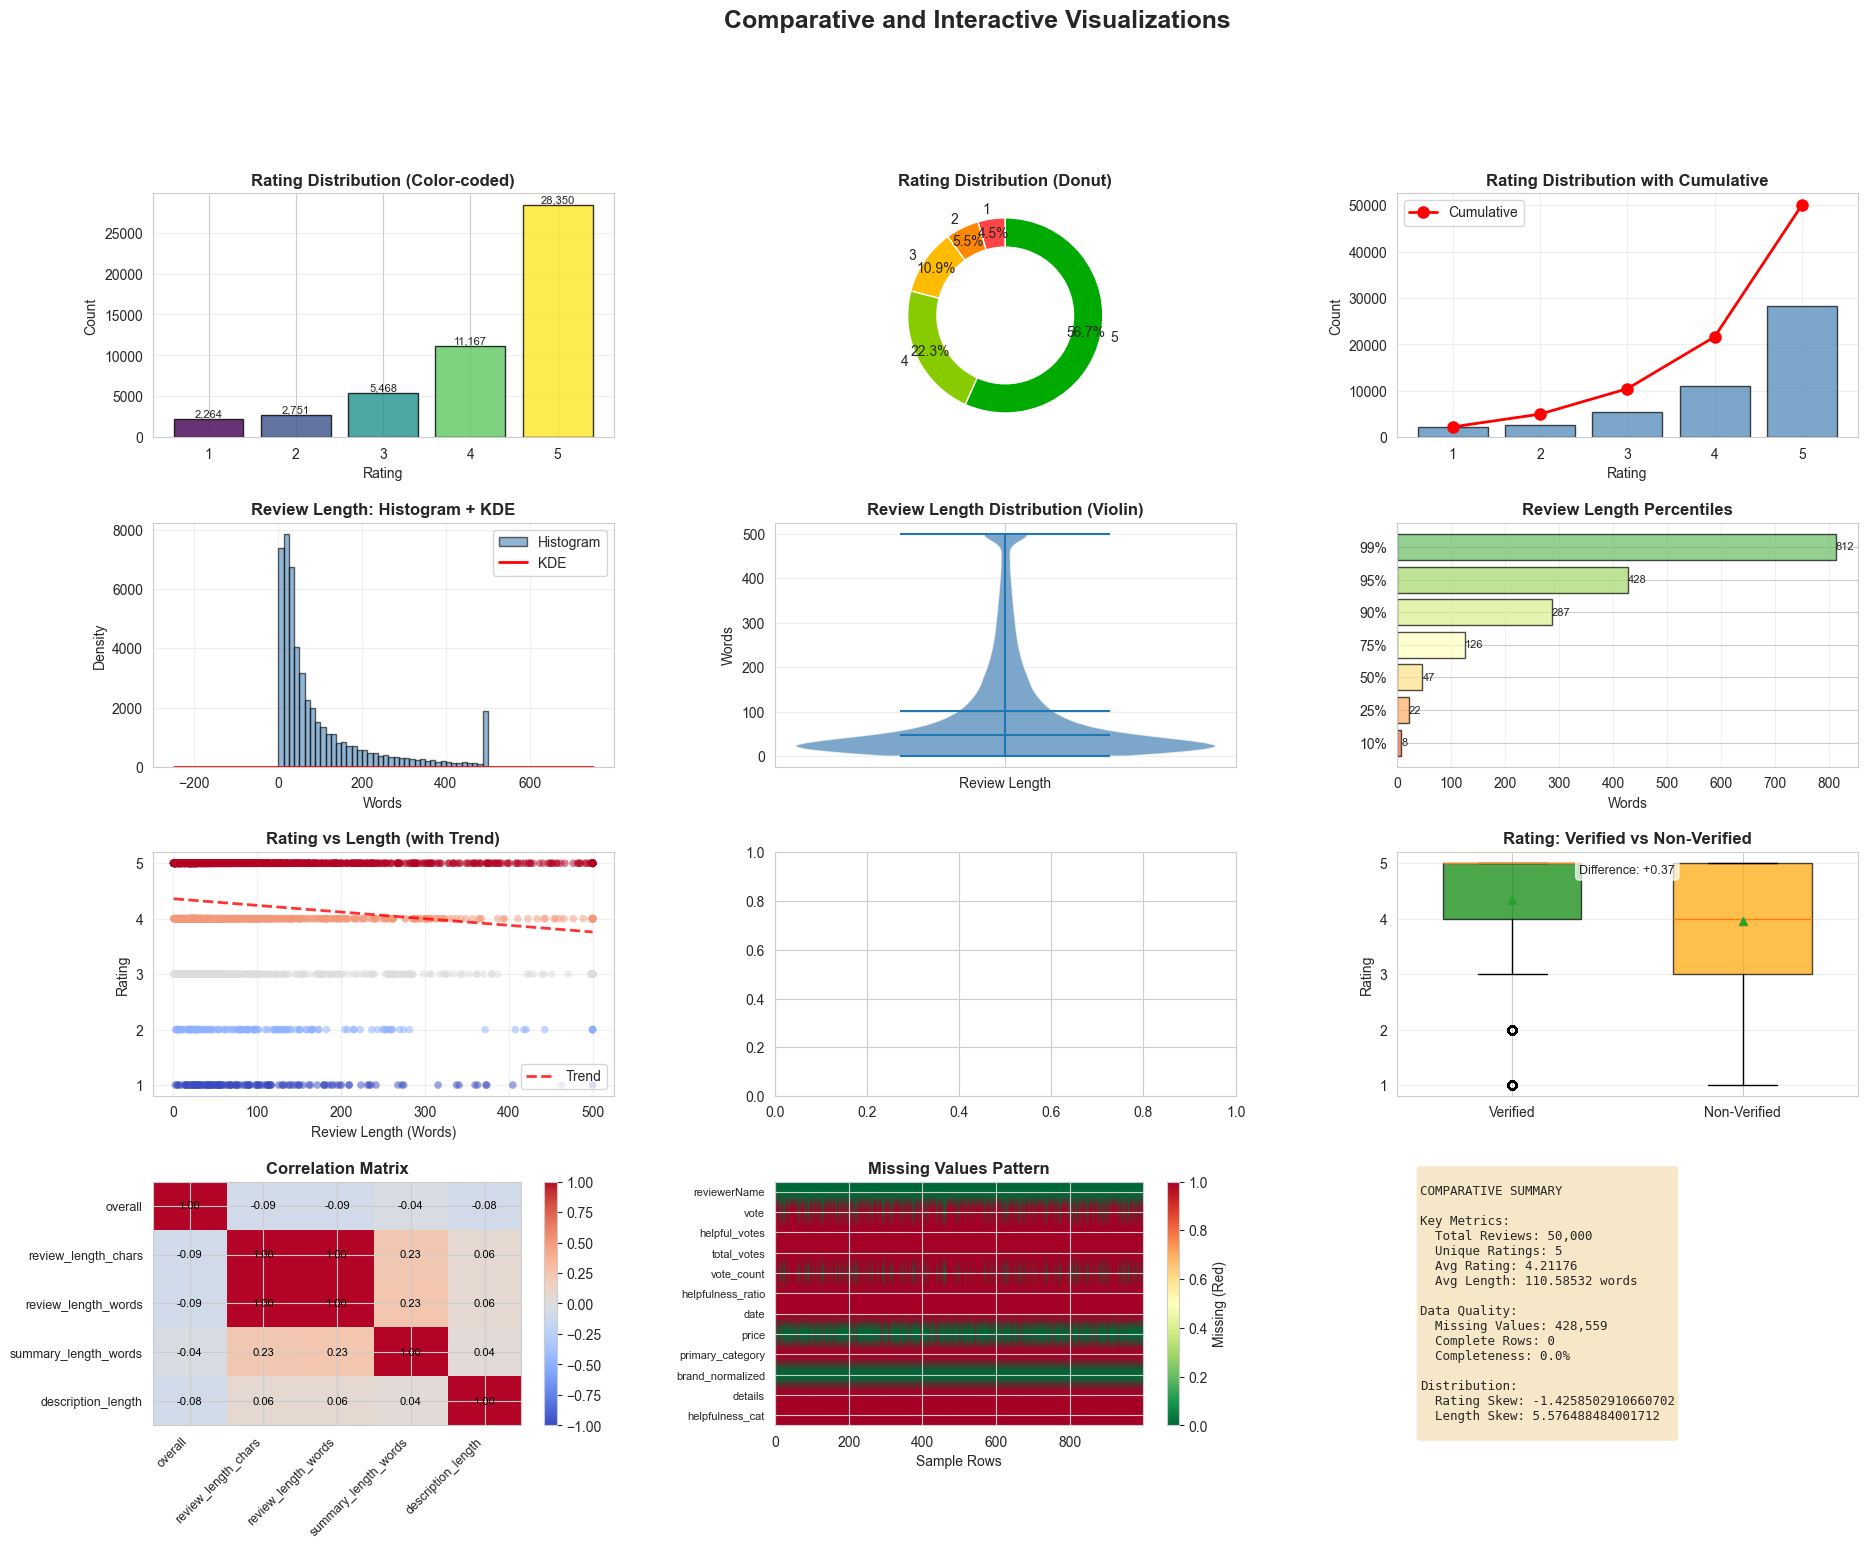


✅ Comparative visualizations created successfully!


In [28]:
# Comparative and interactive-style visualizations
fig = plt.figure(figsize=(22, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.35)

# 1. Multi-panel rating analysis
ax1 = fig.add_subplot(gs[0, 0])
if 'overall' in df_sample.columns:
    rating_counts = df_sample['overall'].value_counts().sort_index()
    colors = plt.cm.viridis(np.linspace(0, 1, len(rating_counts)))
    bars = ax1.bar(rating_counts.index, rating_counts.values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Rating Distribution (Color-coded)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Rating', fontsize=10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}', ha='center', va='bottom', fontsize=8)

# 2. Rating distribution - Donut chart
ax2 = fig.add_subplot(gs[0, 1])
if 'overall' in df_sample.columns:
    rating_counts = df_sample['overall'].value_counts().sort_index()
    colors = ['#ff4444', '#ff8800', '#ffbb00', '#88cc00', '#00aa00']
    wedges, texts, autotexts = ax2.pie(rating_counts.values, labels=rating_counts.index,
                                       autopct='%1.1f%%', colors=colors[:len(rating_counts)],
                                       startangle=90, pctdistance=0.85)
    # Draw circle for donut
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)
    ax2.set_title('Rating Distribution (Donut)', fontsize=12, fontweight='bold')

# 3. Rating distribution - Waterfall style
ax3 = fig.add_subplot(gs[0, 2])
if 'overall' in df_sample.columns:
    rating_counts = df_sample['overall'].value_counts().sort_index()
    cumulative = rating_counts.cumsum()
    ax3.bar(rating_counts.index, rating_counts.values, alpha=0.7, color='steelblue', edgecolor='black')
    ax3.plot(rating_counts.index, cumulative.values, 'ro-', linewidth=2, markersize=8, label='Cumulative')
    ax3.set_title('Rating Distribution with Cumulative', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Rating', fontsize=10)
    ax3.set_ylabel('Count', fontsize=10)
    ax3.legend()
    ax3.grid(alpha=0.3)

# 4. Review length - Multiple distribution views
ax4 = fig.add_subplot(gs[1, 0])
if 'review_length_words' in df_sample.columns:
    review_lengths = df_sample['review_length_words'].clip(upper=500)
    ax4.hist(review_lengths, bins=40, alpha=0.6, color='steelblue', edgecolor='black', label='Histogram')
    review_lengths.plot(kind='kde', ax=ax4, color='red', linewidth=2, label='KDE')
    ax4.set_title('Review Length: Histogram + KDE', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Words', fontsize=10)
    ax4.set_ylabel('Density', fontsize=10)
    ax4.legend()
    ax4.grid(alpha=0.3)

# 5. Review length - Violin plot
ax5 = fig.add_subplot(gs[1, 1])
if 'review_length_words' in df_sample.columns:
    review_lengths = df_sample['review_length_words'].clip(upper=500)
    parts = ax5.violinplot([review_lengths], positions=[1], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor('steelblue')
        pc.set_alpha(0.7)
    ax5.set_xticks([1])
    ax5.set_xticklabels(['Review Length'])
    ax5.set_ylabel('Words', fontsize=10)
    ax5.set_title('Review Length Distribution (Violin)', fontsize=12, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)

# 6. Review length - Percentile bars
ax6 = fig.add_subplot(gs[1, 2])
if 'review_length_words' in df_sample.columns:
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    values = [df_sample['review_length_words'].quantile(p/100) for p in percentiles]
    colors_pct = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(percentiles)))
    bars = ax6.barh(range(len(percentiles)), values, color=colors_pct, alpha=0.7, edgecolor='black')
    ax6.set_yticks(range(len(percentiles)))
    ax6.set_yticklabels([f'{p}%' for p in percentiles])
    ax6.set_xlabel('Words', fontsize=10)
    ax6.set_title('Review Length Percentiles', fontsize=12, fontweight='bold')
    ax6.grid(axis='x', alpha=0.3)
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax6.text(val, bar.get_y() + bar.get_height()/2,
                f'{val:.0f}', ha='left', va='center', fontsize=8)

# 7. Rating vs Length - Multiple views
ax7 = fig.add_subplot(gs[2, 0])
if 'overall' in df_sample.columns and 'review_length_words' in df_sample.columns:
    plot_sample = df_sample.sample(n=min(3000, len(df_sample)), random_state=42)
    scatter = ax7.scatter(plot_sample['review_length_words'].clip(upper=500),
                         plot_sample['overall'], alpha=0.5, s=30,
                         c=plot_sample['overall'], cmap='coolwarm', edgecolors='none')
    # Add trend line
    z = np.polyfit(plot_sample['review_length_words'].clip(upper=500),
                  plot_sample['overall'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(plot_sample['review_length_words'].clip(upper=500).min(),
                         plot_sample['review_length_words'].clip(upper=500).max(), 100)
    ax7.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend')
    ax7.set_title('Rating vs Length (with Trend)', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Review Length (Words)', fontsize=10)
    ax7.set_ylabel('Rating', fontsize=10)
    ax7.legend()
    ax7.grid(alpha=0.3)

# 8. Helpfulness analysis - Multiple metrics
ax8 = fig.add_subplot(gs[2, 1])
if 'helpfulness_ratio' in df_sample.columns:
    helpful_data = df_sample['helpfulness_ratio'].dropna()
    if len(helpful_data) > 0:
        ax8.hist(helpful_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax8.axvline(helpful_data.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {helpful_data.mean():.3f}')
        ax8.axvline(helpful_data.median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {helpful_data.median():.3f}')
        ax8.set_title('Helpfulness Distribution', fontsize=12, fontweight='bold')
        ax8.set_xlabel('Helpfulness Ratio', fontsize=10)
        ax8.set_ylabel('Frequency', fontsize=10)
        ax8.legend(fontsize=8)
        ax8.grid(alpha=0.3)

# 9. Verified vs Non-Verified - Multiple comparisons
ax9 = fig.add_subplot(gs[2, 2])
if 'is_verified' in df_sample.columns and 'overall' in df_sample.columns:
    verified_ratings = df_sample[df_sample['is_verified'] == True]['overall']
    non_verified_ratings = df_sample[df_sample['is_verified'] == False]['overall']
    
    data_to_plot = [verified_ratings.values, non_verified_ratings.values]
    bp = ax9.boxplot(data_to_plot, labels=['Verified', 'Non-Verified'],
                    patch_artist=True, widths=0.6, showmeans=True)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(['green', 'orange'][i])
        patch.set_alpha(0.7)
    ax9.set_title('Rating: Verified vs Non-Verified', fontsize=12, fontweight='bold')
    ax9.set_ylabel('Rating', fontsize=10)
    ax9.grid(axis='y', alpha=0.3)
    diff = verified_ratings.mean() - non_verified_ratings.mean()
    ax9.text(0.5, 0.95, f'Difference: {diff:+.2f}', transform=ax9.transAxes,
            fontsize=9, ha='center', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 10. Correlation network visualization
ax10 = fig.add_subplot(gs[3, 0])
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
key_cols = [col for col in numeric_cols if any(x in col.lower() for x in 
            ['overall', 'length', 'helpful'])]
if len(key_cols) > 1:
    corr_matrix = df_sample[key_cols].corr()
    im = ax10.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax10.set_xticks(range(len(corr_matrix.columns)))
    ax10.set_yticks(range(len(corr_matrix.columns)))
    ax10.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=9)
    ax10.set_yticklabels(corr_matrix.columns, fontsize=9)
    ax10.set_title('Correlation Matrix', fontsize=12, fontweight='bold')
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            text = ax10.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im, ax=ax10)

# 11. Missing values heatmap
ax11 = fig.add_subplot(gs[3, 1])
missing = df_sample.isnull()
if missing.sum().sum() > 0:
    # Sample columns with missing values
    cols_with_missing = missing.columns[missing.sum() > 0][:20]  # Limit to 20 columns
    if len(cols_with_missing) > 0:
        missing_sample = missing[cols_with_missing].sample(n=min(1000, len(df_sample)), random_state=42)
        im = ax11.imshow(missing_sample.values.T, cmap='RdYlGn_r', aspect='auto')
        ax11.set_yticks(range(len(cols_with_missing)))
        ax11.set_yticklabels(cols_with_missing, fontsize=8)
        ax11.set_title('Missing Values Pattern', fontsize=12, fontweight='bold')
        ax11.set_xlabel('Sample Rows', fontsize=10)
        plt.colorbar(im, ax=ax11, label='Missing (Red)')
    else:
        ax11.text(0.5, 0.5, 'No missing values!', ha='center', va='center',
                 transform=ax11.transAxes, fontsize=12, fontweight='bold')
        ax11.set_title('Missing Values Pattern', fontsize=12, fontweight='bold')
else:
    ax11.text(0.5, 0.5, 'No missing values!', ha='center', va='center',
             transform=ax11.transAxes, fontsize=12, fontweight='bold')
    ax11.set_title('Missing Values Pattern', fontsize=12, fontweight='bold')

# 12. Summary statistics panel
ax12 = fig.add_subplot(gs[3, 2])
ax12.axis('off')
summary_text = f"""
COMPARATIVE SUMMARY

Key Metrics:
  Total Reviews: {len(df_sample):,}
  Unique Ratings: {df_sample['overall'].nunique() if 'overall' in df_sample.columns else 'N/A'}
  Avg Rating: {df_sample['overall'].mean() if 'overall' in df_sample.columns else 'N/A'}
  Avg Length: {df_sample['review_length_words'].mean() if 'review_length_words' in df_sample.columns else 'N/A'} words

Data Quality:
  Missing Values: {df_sample.isnull().sum().sum():,}
  Complete Rows: {df_sample.dropna().shape[0]:,}
  Completeness: {df_sample.dropna().shape[0]/len(df_sample)*100:.1f}%

Distribution:
  Rating Skew: {df_sample['overall'].skew() if 'overall' in df_sample.columns else 'N/A'}
  Length Skew: {df_sample['review_length_words'].skew() if 'review_length_words' in df_sample.columns else 'N/A'}
"""
ax12.text(0.05, 0.5, summary_text, fontsize=9, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.suptitle('Comparative and Interactive Visualizations', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(FIGURES_DIR / 'comparative_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparative visualizations created successfully!")


## 10. Statistical Summary and Export


In [29]:
# Generate comprehensive statistical summary and export
print("=" * 80)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 80)

# Create summary statistics dataframe
summary_stats = {}

if 'overall' in df_sample.columns:
    summary_stats['Rating'] = {
        'Count': len(df_sample['overall']),
        'Mean': df_sample['overall'].mean(),
        'Median': df_sample['overall'].median(),
        'Std Dev': df_sample['overall'].std(),
        'Min': df_sample['overall'].min(),
        'Max': df_sample['overall'].max(),
        'Q1': df_sample['overall'].quantile(0.25),
        'Q3': df_sample['overall'].quantile(0.75),
        'Skewness': df_sample['overall'].skew(),
        'Kurtosis': df_sample['overall'].kurtosis()
    }

if 'review_length_words' in df_sample.columns:
    summary_stats['Review Length (Words)'] = {
        'Count': len(df_sample['review_length_words']),
        'Mean': df_sample['review_length_words'].mean(),
        'Median': df_sample['review_length_words'].median(),
        'Std Dev': df_sample['review_length_words'].std(),
        'Min': df_sample['review_length_words'].min(),
        'Max': df_sample['review_length_words'].max(),
        'Q1': df_sample['review_length_words'].quantile(0.25),
        'Q3': df_sample['review_length_words'].quantile(0.75),
        'Skewness': df_sample['review_length_words'].skew(),
        'Kurtosis': df_sample['review_length_words'].kurtosis()
    }

if 'helpfulness_ratio' in df_sample.columns:
    helpful_data = df_sample['helpfulness_ratio'].dropna()
    if len(helpful_data) > 0:
        summary_stats['Helpfulness Ratio'] = {
            'Count': len(helpful_data),
            'Mean': helpful_data.mean(),
            'Median': helpful_data.median(),
            'Std Dev': helpful_data.std(),
            'Min': helpful_data.min(),
            'Max': helpful_data.max(),
            'Q1': helpful_data.quantile(0.25),
            'Q3': helpful_data.quantile(0.75),
            'Skewness': helpful_data.skew(),
            'Kurtosis': helpful_data.kurtosis()
        }

# Convert to DataFrame and display
if summary_stats:
    summary_df = pd.DataFrame(summary_stats).T
    print("\n📊 Summary Statistics:")
    print(summary_df.round(3))
    
    # Save to CSV
    summary_df.to_csv(REPORTS_DIR / 'summary_statistics.csv')
    print(f"\n✅ Summary statistics saved to: {REPORTS_DIR / 'summary_statistics.csv'}")

# Rating distribution summary
if 'overall' in df_sample.columns:
    print("\n" + "=" * 80)
    print("RATING DISTRIBUTION SUMMARY")
    print("=" * 80)
    rating_dist = df_sample['overall'].value_counts().sort_index()
    rating_dist_pct = (rating_dist / len(df_sample) * 100).round(2)
    
    rating_summary = pd.DataFrame({
        'Rating': rating_dist.index,
        'Count': rating_dist.values,
        'Percentage': rating_dist_pct.values
    })
    print(rating_summary.to_string(index=False))
    
    # Save rating distribution
    rating_summary.to_csv(REPORTS_DIR / 'rating_distribution.csv', index=False)
    print(f"\n✅ Rating distribution saved to: {REPORTS_DIR / 'rating_distribution.csv'}")

# Missing values summary
print("\n" + "=" * 80)
print("MISSING VALUES SUMMARY")
print("=" * 80)
missing = df_sample.isnull().sum()
missing_pct = (missing / len(df_sample)) * 100
missing_summary = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing Percentage': missing_pct.values
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_summary) > 0:
    print(missing_summary.to_string(index=False))
    missing_summary.to_csv(REPORTS_DIR / 'missing_values_summary.csv', index=False)
    print(f"\n✅ Missing values summary saved to: {REPORTS_DIR / 'missing_values_summary.csv'}")
else:
    print("✅ No missing values found!")

# Correlation summary
print("\n" + "=" * 80)
print("CORRELATION SUMMARY")
print("=" * 80)
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
key_cols = [col for col in numeric_cols if any(x in col.lower() for x in 
            ['overall', 'length', 'helpful'])]
if len(key_cols) > 1:
    corr_matrix = df_sample[key_cols].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(3))
    
    # Save correlation matrix
    corr_matrix.to_csv(REPORTS_DIR / 'correlation_matrix.csv')
    print(f"\n✅ Correlation matrix saved to: {REPORTS_DIR / 'correlation_matrix.csv'}")

print("\n" + "=" * 80)
print("✅ ALL STATISTICAL SUMMARIES EXPORTED SUCCESSFULLY!")
print("=" * 80)
print(f"\nAll reports saved to: {REPORTS_DIR}")
print(f"All figures saved to: {FIGURES_DIR}")


COMPREHENSIVE STATISTICAL SUMMARY

📊 Summary Statistics:
                         Count     Mean  Median  Std Dev  Min     Max    Q1  \
Rating                 50000.0    4.212     5.0    1.122  1.0     5.0   4.0   
Review Length (Words)  50000.0  110.585    47.0  175.876  1.0  5281.0  22.0   

                          Q3  Skewness  Kurtosis  
Rating                   5.0    -1.426     1.157  
Review Length (Words)  126.0     5.576    71.553  

✅ Summary statistics saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\reports\summary_statistics.csv

RATING DISTRIBUTION SUMMARY
 Rating  Count  Percentage
      1   2264        4.53
      2   2751        5.50
      3   5468       10.94
      4  11167       22.33
      5  28350       56.70

✅ Rating distribution saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\reports\rating_distribution.csv

MISSING VALUES SUMMARY
           Column  Missing Count  Missing Percentage
      total_votes 

In [30]:
print("=== EDA SUMMARY ===")
print(f"\nDataset: {len(df_sample):,} rows, {len(df_sample.columns)} columns")
print(f"\nKey Findings:")
if 'overall' in df_sample.columns:
    print(f"1. Rating distribution: {dict(df_sample['overall'].value_counts().sort_index())}")
if 'review_length_words' in df_sample.columns:
    print(f"2. Average review length: {df_sample['review_length_words'].mean():.0f} words")
if 'is_verified' in df_sample.columns:
    print(f"3. Verified purchase rate: {df_sample['is_verified'].sum() / len(df_sample) * 100:.1f}%")

print("\n=== NEXT STEPS ===")
print("1. Complete detailed statistical analysis")
print("2. Generate additional visualizations")
print("3. Document findings in EDA report")
print("4. Prepare for Phase 4: Sentiment Modeling")


=== EDA SUMMARY ===

Dataset: 50,000 rows, 57 columns

Key Findings:
1. Rating distribution: {1: np.int64(2264), 2: np.int64(2751), 3: np.int64(5468), 4: np.int64(11167), 5: np.int64(28350)}
2. Average review length: 111 words
3. Verified purchase rate: 65.9%

=== NEXT STEPS ===
1. Complete detailed statistical analysis
2. Generate additional visualizations
3. Document findings in EDA report
4. Prepare for Phase 4: Sentiment Modeling
